# **FS25 NLP Project 2: Transformers**

Fabian Dubach

# **Introduction**

<style>
  .container {
    display: flex;
    align-items: flex-start;
    gap: 20px; /* spacing between text and ASCII art */
    font-family: monospace;
  }
  .text {
    flex: 2;
  }
  .ascii {
    white-space: pre;
    font-size: 4.5px;
    line-height: 1.2;
    flex: 1;
  }
</style>

<div class="container">
  <div class="text">
    <p>The task for my project was to perform common sense question answering using the CommonsenseQA dataset, which is a multiple-choice question answering dataset that contains 12'247 different questions and was developed to benchmark machine understanding of everyday knowledge. For each questions there are 5 given answer choices, where only one of them is correct. To be able to answer these questions, "commonsense" is needed. The dataset is available on HuggingFace: <a href="https://huggingface.co/datasets/tau/commonsense_qa" target="_blank">https://huggingface.co/datasets/tau/commonsense_qa</a>.</p><br>
    <p>I evaluated the performance of three different Transformer-based models:</p>
    <p>1. A randomly initialized Transformer</p>
    <p>2. A pretrained Transformer (with the same architecture as the first Transformer)</p>
    <p>3. A large language model (LLM) with over 1 billion parameters</p><br>
    <p>While the first two models were finetuned on the dataset using the same hyperparameters for a fair comparison, the LLM was evaluated through prompt engineering without additional training. For the training of the first two models, I used a bayesian sweep. This setup allowed me to explore how different levels of pretraining and model scale impact common sense reasoning performance.</p>
    <p>We had to also track the trainings with Wandb (view URL: <a href="https://wandb.ai/fabian-dubach-hochschule-luzern/CommonsenseQA/workspace?nw=9kw2opdx278" target="_blank">https://wandb.ai/fabian-dubach-hochschule-luzern/CommonsenseQA/workspace?nw=9kw2opdx278</a>).</p>
  </div>

  <div class="ascii">
<pre>
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠀⠀⠀⠀⠀⣤⣤⣤⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⣠⡶⢿⡇⢿⣿⡏⢳⣦⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⡛⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣧⣼⣿⣴⣋⡽⠮⠿⢭⣟⣏⣷⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣧⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡼⣇⣿⡿⠶⣶⣿⣟⡛⣷⣿⢠⠙⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⡈⣏⠇⢹⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡟⢹⠁⣿⠋⠉⢹⠉⠙⣿⡇⣾⣀⣾⠀⢀⣤⡀⢀⡀⠀⠀⢀⣠⣴⣾⠛⢻⡛⢻⡄⢀⣳⡀⢀⣠⠄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⣷⣾⢀⣿⡇⠀⠸⠀⠀⣿⣧⡽⠿⣟⣺⣭⠴⢿⡏⣩⣷⡾⢛⣭⣴⣿⣇⠘⣿⣷⣿⡛⠉⢻⣟⣷⠄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠿⢿⣟⣿⣿⡦⣶⣪⡭⠿⣚⣫⣭⣽⣶⡄⠀⢸⡇⣿⡙⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣷⡀⠀⢿⡉⠁⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣤⣶⣿⠿⠛⣉⣭⣶⣾⣿⠿⠟⠛⠉⠉⢻⠀⢸⣷⣿⣇⢻⡿⣿⣿⣿⣿⠟⠀⠹⣿⣿⠃⠀⠘⣷⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⣦⣼⣿⠿⠛⣋⡁⣼⢠⣿⡿⠛⠉⠁⠀⠀⢀⡀⢀⣴⣾⠀⢸⣿⡇⢻⡄⠙⠿⠻⠛⠁⠀⢀⣠⣽⣿⣇⡀⠀⠸⣧⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣾⠿⣛⣭⣴⡾⠟⠛⣧⣿⢸⡿⠀⠀⠀⠀⣰⣿⣿⣷⣾⣿⣿⠀⢸⡏⣇⢸⣷⡀⠀⢀⣠⣴⣾⠿⠛⣿⢻⣿⣹⡀⠀⢻⣆⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⡟⣦⠀⠀⠀⢀⡿⣵⡿⠛⠉⣡⣶⣤⣄⣿⣯⢸⣇⠀⠀⢠⣾⣿⡿⣿⣿⣿⣿⡿⠀⢸⡇⢻⡼⣿⣷⣶⠿⠛⠉⠀⠀⠀⠸⡇⣿⣿⣧⠀⠘⣿⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⢹⠀⢀⣠⣼⣿⣿⠀⢀⣼⣿⣿⣿⣿⡇⣿⢸⣿⣀⣀⣿⡿⠿⠶⠚⠛⠉⠉⠀⠀⢸⡇⠀⢻⣾⣝⣿⡆⠀⢀⣠⡴⠖⠛⢻⡾⣿⣿⣆⠀⢹⡇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣇⣼⡾⠟⠋⣿⢻⣇⣤⣌⠻⢿⣿⣿⣿⠃⢿⠀⠉⠉⠁⠀⠀⠀⣀⣤⡤⠶⠶⠒⠚⣻⣷⣄⠈⣿⣿⣿⣿⡞⠉⠀⠀⠀⠀⠀⣿⢿⣿⣾⣋⣽⠇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣹⠏⠀⠀⠀⣿⢿⣿⣿⣯⡴⠾⠛⢋⣡⠶⠛⠛⠋⣉⣉⣉⣙⢻⣿⠀⠀⠀⠀⠀⢠⡟⠀⠈⠻⢦⣈⣿⣿⣧⠀⠀⢀⣠⣴⡾⢿⣿⣿⣿⣿⣿⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡟⣿⡟⠀⠀⠀⣿⠈⠋⠉⢀⣠⠴⣛⣩⣤⣶⣞⣭⣿⢿⣿⣿⣻⣼⣿⣆⣀⣤⣤⣴⣿⣄⣠⣶⣦⣀⣙⣿⣿⣿⡶⣿⠟⠋⣁⣶⠟⢻⣽⣿⣿⣿⠇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⢠⣿⣇⠀⠀⠀⢹⣠⡴⠖⢻⣷⢫⣿⣿⣿⣯⣿⣟⣿⣿⣭⣽⣿⡿⣿⣿⣿⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⠋⠉⣿⠀⢸⣿⣿⣿⣿⣷⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣼⣿⣿⣤⣴⣾⢿⡅⠀⣀⣾⢿⣿⣿⣿⣿⣿⣿⡿⣿⣷⣿⣿⣿⡇⣿⣿⡇⠀⠀⢸⣿⣿⡟⢿⣿⣿⣿⣿⣿⣣⣿⠁⣿⣀⣤⡿⠀⢀⣿⣿⣿⣿⣿⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠻⣿⠛⠉⠀⠈⣿⠛⢽⣿⢻⣿⣿⢿⣿⣿⣿⡇⣿⠿⣶⣶⣚⣧⣿⣿⡇⠀⠀⣸⣿⣿⣿⣄⣈⢿⣿⢿⣷⣿⣿⠀⠉⠉⠀⠀⠀⠘⡇⣿⣿⣿⣿⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⡀⣷⡆⠀⠀⠀⠸⣧⣻⣿⢸⣿⣿⡿⢿⣾⣻⡇⣿⣿⣿⣿⣿⣿⣿⠿⠷⠾⠛⠛⠿⢿⣿⣿⣿⣄⣿⠿⠋⢸⣿⠀⠀⠀⠀⠀⠀⠀⡇⣿⣿⣿⣿⣿⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣷⡇⣿⡇⠀⠀⠀⠀⣿⣿⣿⡾⢿⣿⣿⣿⣿⡶⠷⠾⠛⠛⠉⠁⢀⣠⠤⠴⠒⡆⢠⠀⢰⡉⠻⣿⣽⡏⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⡇⣿⡿⣿⣿⣿⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣧⣿⠿⢀⣀⣤⣴⣿⣿⣿⡷⠾⠛⠋⠉⢀⣀⣠⠤⠴⠒⠻⡆⢸⠀⠀⢀⡠⠇⠸⡄⠈⣇⠀⠈⡻⢦⡀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⡇⣿⣧⡘⠿⢻⡆
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣆⣿⣿⣿⣿⣿⡿⠛⣉⣀⡀⣠⠴⠒⠋⠉⠁⠀⠀⠀⠀⠀⡇⢸⣠⠴⣫⡄⠀⠀⡇⠀⢹⠀⠀⣿⠦⢿⡀⢸⡇⠀⠀⣀⣤⣤⣿⠀⡇⣿⣿⣿⣆⢸⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣿⢿⡟⣽⣿⠀⣏⠁⠀⡇⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣇⠀⡖⣻⠋⠀⠀⠈⢻⠀⢈⡇⠀⠸⡄⠘⣧⢸⡇⠀⢸⣷⣾⣿⠏⠀⡇⣿⣿⣿⣿⢸⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣾⠏⠛⠋⢡⣿⠀⠸⣿⣟⡃⣇⠀⠀⠀⠀⠀⣀⣠⡤⠶⠒⠋⠀⠛⠁⠀⣀⣤⣶⣿⣿⣿⣿⣷⣤⡈⠁⢻⡞⣿⠀⠈⠻⣴⠏⠀⠀⠿⢹⣿⣎⢻⣿⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣾⡟⠀⠀⢀⡿⣿⠀⠀⠈⠳⡇⠻⠤⠶⠚⠋⠉⠁⠀⠀⠀⠀⠀⣀⣤⣶⣿⣿⣿⣿⣿⠿⠛⠻⣿⣿⣿⣷⣜⣷⣿⠀⠀⢀⣀⣤⣤⣶⣾⣶⣿⣿⠃⢸⡇
⠀⠀⠀⠀⠀⠀⣀⣤⡶⠶⠖⠚⢛⠛⠳⢶⣼⡟⠀⠀⢀⣼⣹⣿⢀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⢀⣀⣠⡤⢤⣾⣿⣿⣿⡿⠿⠛⠉⠹⡇⠀⠀⣿⣿⣟⢿⣿⣿⠹⣶⣿⡿⠛⠻⣏⠀⠉⠉⡛⣿⡿⣾⡇
⠀⠀⠀⢀⣴⠞⠋⢰⡇⢰⣿⢻⢻⢻⢶⣦⠙⣷⡀⠀⣸⢧⠟⢿⣿⣿⣿⣷⣶⣶⣤⣴⣲⡾⠿⠟⠒⠒⠛⡇⠙⣿⠉⠀⢧⠀⠀⠀⠀⣧⠀⠀⢸⣿⣿⡎⣿⠁⢀⣼⣏⢀⣠⣤⣸⣶⠀⠀⣿⣿⣿⠛⠁
⠀⠀⠀⣾⠃⠀⣠⡬⣤⣼⣛⠾⣼⣞⡾⡟⠀⠘⣧⣠⣏⡞⠀⠈⠻⣿⡏⢹⡟⠛⠻⣿⠁⠀⠀⠀⠀⠀⠀⣇⠀⣿⠀⠀⢸⡄⠀⠀⠀⢸⠀⠀⠘⣿⣿⣇⣿⣴⡞⢣⣽⣿⣿⣿⣿⣿⠀⠀⣿⣿⡟⠀⠀
⠀⠀⠀⣿⡶⣿⣿⣸⣿⣿⣿⠿⠷⠾⢽⣅⡲⠶⢻⣿⣼⢁⣠⣤⣶⣿⣿⠘⡇⠀⠀⢻⡆⠀⠀⠀⠀⠀⢀⣸⡀⢹⡇⠀⠈⡇⠀⠀⠀⠈⡇⠀⠀⢿⣿⣿⢹⣿⣤⣿⣿⣿⣿⡿⢿⣟⡀⠀⣿⣿⡇⠀⠀
⠀⠀⠀⠈⠛⠿⢯⣜⣿⠏⠀⠀⠀⢀⡿⣨⣿⣶⣤⣿⣷⣯⣿⣿⣿⣿⣿⠀⡇⠀⠀⠐⡿⣦⣰⣒⣶⣿⣿⣿⣷⣾⣇⠀⠀⢻⠀⠀⠀⠀⢷⠀⠀⢸⣿⣿⣾⣿⣸⣿⡏⢠⠟⣠⣿⣿⣿⣦⡈⢹⡇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⢸⡟⣾⠄⠀⠀⣸⡇⣿⣿⣿⠟⠋⠛⢿⣿⣿⣿⣿⣿⡄⢻⠀⠀⠀⡇⠈⠙⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⢸⡆⠀⠀⠀⢸⡄⠀⠀⣿⣿⣇⣿⠛⠛⠻⣿⣺⣿⣿⣿⣿⣿⣿⡿⠃⠀⠀
⠀⠀⠀⠀⠀⠀⠀⣼⢧⡇⠀⠀⠀⣿⢸⣿⣿⡿⢦⣴⣿⣿⣷⡿⣿⡿⣿⡇⢸⡄⠀⠀⢹⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⡆⠀⠀⣇⠀⠀⠀⠀⣇⠀⠀⢸⣿⣟⢿⡀⠀⠀⠈⠉⠀⠉⠉⠉⠁⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⣿⣨⡧⠤⠤⢤⣇⡾⣿⣿⣠⣿⣿⣿⣿⣿⣿⣽⣿⣿⣷⠀⣇⠀⠀⢸⠀⠀⢸⢻⣿⣿⣿⣿⡇⣿⣿⠀⠀⢹⡄⠀⠀⢀⣸⠀⠀⠸⣿⣿⣼⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⢀⡿⣧⣤⠶⠦⣼⣿⣿⣿⡏⠈⣿⣿⢿⣿⣿⣿⣏⠉⢹⣿⡀⢻⠀⠀⠘⡇⠀⠸⡄⠙⢿⣿⣿⠇⣿⣿⡄⠀⠈⠓⠒⠋⠉⠀⠀⠀⠀⢿⠹⣯⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣸⣿⢃⡏⠀⠀⢻⣿⣿⣽⣿⣦⠘⣿⣿⣿⣿⣿⢻⣿⣾⣿⡇⠘⡇⠀⠀⣇⠀⠀⣇⠀⠀⠙⢿⡇⣿⢸⣧⠀⠀⠀⠀⡴⠒⢶⠀⠀⠀⠘⣆⠀⢻⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⡿⡅⣸⢁⣄⡄⣾⣿⢿⣿⠿⣿⣿⢻⣿⣿⣟⣿⣸⣻⡿⣿⣧⠀⠙⠒⠛⠛⠀⠀⢿⣿⣄⠀⠀⠀⣿⠈⣿⡄⠀⠀⠀⡇⠀⠘⡇⠀⠀⠀⢿⣦⢸⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢸⣧⡇⣿⣼⣿⠃⣿⣿⣾⣿⣷⣤⡿⠿⢿⣿⣿⣇⣿⡟⠋⠀⣿⡀⠀⣴⠲⡆⠀⠀⠸⣿⣿⣦⠀⠀⢸⡀⢹⣧⠀⠀⠀⣇⠀⠀⢹⠀⠀⠀⠸⣿⡟⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⢽⡿⣷⠏⠛⠿⢠⣿⣿⣿⣿⢿⣯⡇⠀⠀⠈⠁⠀⠀⠀⠀⠀⢸⣇⠀⢻⠀⢳⠀⠀⠀⣿⣿⣿⣷⣾⢸⡇⠈⣿⡀⠀⠀⢸⠀⠀⠈⡇⠀⠀⢀⣿⣿⣷⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠘⣧⡙⣀⣀⣀⣸⣿⣽⣿⣿⠀⠈⠙⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡀⢸⡀⠸⡄⠀⠀⢻⣿⣿⣿⣿⡼⡇⠀⢘⣧⣤⡴⠾⠷⠶⠖⠛⠛⢛⠋⠉⢿⢹⠉⣭⡿⠿⠷⠶⢦⡄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠹⣟⣁⣸⣿⣿⣧⡿⠿⣿⣀⡀⠀⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣇⣈⣧⣘⣷⣤⣤⣼⠿⠿⣿⣿⣧⣧⡀⣸⢹⡏⠀⠀⠀⠀⠀⠀⠀⠈⡇⠀⢸⢸⡄⡿⠖⠚⠉⡉⠓⢿⡀⠀⠀⠀⠀
⠀⠀⠀⠀⣠⡴⣾⠋⠉⢙⣻⣷⠛⠛⠳⠶⠶⠽⠿⠃⠀⠀⠀⠀⠀⣀⡤⣼⡿⠋⠉⠁⠀⠀⣠⠀⣿⣿⠀⠀⠀⠀⠈⠉⠻⣿⢸⣷⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠸⡏⡇⣿⠀⠀⠀⢻⣷⢸⡇⠀⠀⠀⠀
⠀⠀⠀⠀⡟⠀⡟⠀⠀⢸⣿⣿⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣾⡥⢺⠏⡆⠀⠀⠀⠀⠀⡏⠀⡟⡇⠀⠀⠀⠀⠀⠀⢀⡇⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⡇⡇⢿⠀⠀⠀⢸⣿⡌⣷⠀⠀⠀⠀
⠀⠀⠀⢸⠇⢠⡇⠀⠀⢰⣿⣯⣏⣻⡆⠀⠀⠀⠀⠀⠀⠀⠀⣸⠃⢀⡿⢸⡇⠀⠀⠀⠀⢠⡇⠀⡇⡇⠀⠀⠀⠀⠀⠀⢸⡇⢸⣿⡆⠀⠀⠀⠀⠀⠀⠀⣧⠀⠀⡇⢿⢸⠀⠀⠀⠈⣿⡇⢹⡀⠀⠀⠀
⠀⠀⠀⡟⡄⣼⠀⠀⢀⣿⣿⣿⣿⣿⣷⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⢸⡇⣸⡇⠀⠀⠀⠀⢸⠁⢸⣷⡇⠀⠀⠀⠀⠀⠀⢸⡇⢸⣿⡇⠀⠀⠀⠀⠀⠀⠀⢻⠀⠀⢹⢸⣼⡀⠀⣀⣀⣿⣧⣸⡇⠀⠀⠀
⠀⠀⢰⢧⣇⡏⠀⠀⣸⣿⠿⢭⣿⣿⡏⠀⠀⠀⠀⠀⠀⠀⢰⡏⠀⣿⠀⣿⡇⠀⠀⠀⠀⢸⠀⢸⢸⠁⠀⠀⠀⠀⠀⠀⢸⡇⢸⣿⣿⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⢸⢸⣿⡏⢉⣁⣤⣤⣄⢈⡇⠀⠀⠀
⠀⠀⣼⢼⣿⠃⠀⠀⣿⣿⠀⢸⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⢸⡇⢠⡿⢰⣿⠃⠀⠀⠀⠀⣼⠀⢸⢸⠀⠀⠀⠀⠀⠀⠀⢸⡇⢸⢹⣸⣦⣤⣤⣤⣶⣶⣶⡿⠀⠀⢸⡄⡇⣧⣽⣿⣿⣿⡽⠟⠁⠀⠀⠀
⠀⠀⢿⢻⡏⠀⠀⢰⣿⣿⣟⠛⢿⣿⡇⠀⠀⠀⠀⠀⠀⠀⢸⠗⣻⡇⢸⢹⣆⣀⣀⣀⣤⡏⠀⢸⢸⠀⠀⠀⠀⠀⠀⠀⢸⡇⢸⠈⠉⠉⠉⠉⠉⠉⠀⠀⠀⠀⠀⠈⡇⣿⠘⣿⣿⣿⣇⠀⠀⠀⠀⠀⠀
⠀⠀⢸⠛⠤⢤⣤⣘⢺⣿⣿⣿⣿⡿⠃⠀⠀⠀⠀⠀⠀⠀⠸⢧⣿⠃⠘⠓⠛⠛⠛⠋⠉⠁⠀⢼⢸⠀⢰⡾⠿⠛⠛⠿⢿⡇⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⢸⠀⠙⣿⣿⣿⠀⠀⠀⠀⠀⠀
⠀⠀⢘⣶⡶⠚⠿⢿⣿⣩⢿⢿⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣸⠀⢸⡇⠀⠀⠀⠀⣿⡇⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢷⢸⡀⠀⠈⠁⢸⡇⠀⠀⠀⠀⠀
⠀⠀⣼⣹⠃⠀⢰⣷⢻⠁⠈⠛⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡟⣹⠀⢸⠃⠀⠀⠀⠀⣿⠇⠜⠀⣤⠶⠖⠛⠛⠋⠉⠉⢩⣿⡇⠀⢸⠸⡇⠀⠀⠀⠘⡇⠀⠀⠀⠀⠀
⠀⢠⡟⠏⠀⠀⣾⣿⣼⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⡇⠀⢀⣴⠶⠞⠛⠛⣻⣷⠀⡏⣿⠀⢸⢀⣴⣷⣦⡀⣿⠇⡇⠀⡟⠀⣀⣀⣀⣀⣀⣀⣸⣿⡇⠀⢸⡆⡇⠀⠀⠀⠀⣷⠀⠀⠀⠀⠀
⠀⣸⠇⠀⠀⢸⣿⡇⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⣾⣀⣀⣤⣤⣶⣿⡿⠀⡇⣿⠀⢸⣿⣿⣿⣫⣾⣿⠀⡇⢠⣟⣿⣿⣿⡿⠿⠿⠿⠿⠁⡇⠀⠈⡇⣷⢀⡀⠀⠀⢻⠀⠀⠀⠀⠀
⠀⣿⡼⠀⠀⡟⣿⣷⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⣿⠀⢀⡟⡿⠿⠟⠛⠛⣃⡇⠀⡇⣿⠀⢸⣿⣿⣿⣿⣿⣿⡄⡇⢸⡇⠀⠀⠀⠀⠀⠀⠀⢰⣶⡇⠀⠀⣇⢹⣾⣿⠀⣰⢾⡆⠀⠀⠀⠀
⢠⣿⡇⠀⢸⣷⣿⣹⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⠀⢸⡇⠀⠀⠀⠀⢰⣿⡇⠀⡇⣿⠀⣾⣿⣿⣿⣿⣿⣿⡃⡇⢸⣧⣤⣤⣴⣶⣶⣶⣶⣾⣿⡇⠀⠀⢿⢸⣿⣿⣾⣿⣸⡇⠀⠀⠀⠀
⢸⢭⠥⠦⣬⣽⣧⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⣿⠀⢸⢵⣶⣾⣿⣿⣿⡿⡇⠀⡇⣿⠀⣿⣿⣿⣿⣿⣿⣿⡇⡇⢸⡏⠿⠟⠛⠛⠛⠛⠛⠛⣧⣷⠀⠀⢸⠀⣿⣿⣿⣿⠛⣇⠀⠀⠀⠀
⢸⣸⠁⢠⣿⣿⣹⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⢸⠉⠉⠉⠁⠀⢠⣾⡇⠀⡇⣿⠀⣿⣿⣿⣿⣿⣿⣿⠇⡇⢸⡇⠀⣀⣀⣀⣀⣀⣀⣰⣿⣿⠀⠀⠸⠀⣿⣿⣿⣵⡇⣿⠀⠀⠀⠀
⠘⣧⣰⠞⣞⣷⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⢸⣀⣀⣠⣤⣤⣼⣿⡇⠀⡇⣿⠀⢈⣭⣭⠭⠽⠭⣿⡇⡇⢸⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡀⠀⠀⠀⢻⣟⣾⣿⣿⢻⠀⠀⠀⠀
⠀⠈⠛⠛⠛⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⠀⣿⠿⠿⠿⠿⠟⢛⣻⡇⠀⡇⢻⠀⢸⠁⠀⠀⠀⠀⣿⡇⡇⠸⡏⠉⠀⠀⠀⠀⠀⠀⠀⣼⣿⡇⠀⠀⠀⢸⣿⣿⣿⣿⢸⡆⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣇⠀⣿⣀⣤⣤⣤⣤⣼⣿⡇⠀⡇⢸⠀⢸⠀⣠⣶⣄⠀⣿⡇⣇⠀⡇⣴⣶⣶⣾⣿⣿⣿⣿⣿⣿⣇⣀⣂⠀⢸⣿⣿⣿⣿⣿⡇⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣿⡿⠴⠿⠿⠿⠿⠿⠿⠿⠿⠷⣦⡄⢸⠀⢸⣾⣿⣿⢟⣴⣿⣷⣼⠶⠗⠛⠛⠛⠛⠛⠛⠛⠋⠉⠉⠉⢉⡟⣧⠈⣿⣿⣿⣿⡿⣧⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣿⡇⢸⣴⢾⣿⡿⣻⣿⣿⣿⣿⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⠀⣿⣿⣿⣿⣿⣿⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣾⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⣿⣿⡇⢸⣿⢸⣿⣿⣿⣿⣿⣿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⣿⣿⡀⣿⣿⣿⣿⣿⣿⡄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⣿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣾⣿⣿⣿⡇⢸⣿⢸⣿⣿⣿⣿⣿⠃⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣿⣿⣿⡇⢸⣿⣿⣿⣿⢻⡇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⣿⣷⣶⣶⣶⣶⣶⣶⣶⡶⠶⠦⠤⣾⣿⣿⣿⣿⣷⢘⣿⢸⣿⣿⣿⣿⡏⣭⠭⠭⠭⠤⠤⠤⠴⠶⠶⠶⠶⠶⠶⠶⠱⣌⢻⣿⣧⢸⣿⣿⣿⣿⣾⣇⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⡾⠟⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⣉⣽⣿⣾⣿⣿⣿⣿⣿⠀⣿⢸⣿⣿⣿⡟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⡞⣿⢻⠈⣿⣿⣿⣿⣿⣿⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣶⠟⠋⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⣴⣾⣿⣿⣿⣿⣿⣿⣿⠛⢹⠀⣿⣾⣿⣿⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⣿⣿⣿⢻⣿⡀⣿⣿⣿⣿⣿⣿⡄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣾⣿⣀⣤⣄⣤⣤⣄⣀⣀⣀⣀⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣅⢸⠀⣿⡿⣿⣿⣤⣤⣤⡤⠤⠤⠶⠶⠶⠖⠒⠒⠒⠚⠛⠛⠛⠺⣿⣿⣿⡇⠹⡇⣿⣿⣿⣿⣿⣿⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⣸⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣿⣿⣿⣿⡟⠉⢹⣿⣿⣿⣿⡿⠿⡾⠀⣿⡇⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⠰⠇⣿⣿⣿⣿⡿⣿⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡟⠛⠉⠁⠀⠀⠀⠙⠛⠉⠁⠀⠀⠁⠀⣛⣁⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⠟⣹⡇⢀⣙⣿⣯⡷⠿⠛⠁⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠉⠉⠉⠉⠉⠉⠹⠷⣦⣤⣤⣤⣤⣤⣤⣤⣤⣤⣶⣶⣶⡶⠶⠶⠶⠶⠾⠿⠛⠛⠋⠉⠉⠁⠀⠀
</pre>
  </div>
</div>

# **Setup**

Install all dependencies needed for Windows/Linux.

In [1]:
if False:
    %pip install pandas==2.2.3
    %pip install numpy==1.26.4
    %pip install matplotlib==3.10.1
    %pip install seaborn==0.13.2
    %pip install torch==2.6.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.6.0+cu118 -f https://download.pytorch.org/whl/cu118/torch_stable.html
    %pip install transformers==4.37.0
    %pip install datasets==3.3.2
    %pip install tqdm==4.67.1
    %pip install wandb==0.19.8
    %pip install bitsandbytes==0.41.1
    %pip install accelerate==0.25.0
    %pip install scikit-learn==1.3.2

Install all dependencies needed for MacOS.

In [2]:
if False:
    %pip install pandas==2.2.3
    %pip install numpy==1.26.4
    %pip install matplotlib==3.10.1
    %pip install seaborn==0.13.2
    %pip install torch==2.6.0 torchvision==0.17.0 torchaudio==2.6.0
    %pip install transformers==4.37.0
    %pip install datasets==3.3.2
    %pip install tqdm==4.67.1
    %pip install wandb==0.19.8
    %pip install coremltools
    %pip install bitsandbytes==0.41.1
    %pip install accelerate==0.25.0
    %pip install scikit-learn==1.3.2

Import all libraries needed.

In [3]:
import os
import gc
import re
import pandas as pd
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    BertConfig,
    BertForMultipleChoice,
    BertTokenizer,
    AutoTokenizer,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup,
    GenerationConfig,
    BitsAndBytesConfig,
)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
)
from datasets import load_dataset
from tqdm import tqdm
import wandb

Setup random seed function to ensure reproducibility.

_Info about the seed value: The field of natural language processing began in the 1940s, after World War II. At this time, people recognized the importance of translation from one language to another and hoped to create a machine that could do this sort of translation automatically. → Seed value is mostly set to 42_

In [4]:
SEED = 1940

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In the next step I import and split the dataset. For the split I take off the last 1000 entries from the train-split and use it as validation, the rest of this is of course used for the training. Then I use the validation-part as the test, since the real test-split has no answer keys.

In [5]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


I already define the GPU as my device, that I can just simply refer to this variable.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Login for the experiment tracking.

In [7]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fabian-dubach (fabian-dubach-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Next, I set some variables to be able to run the whole notebook without starting a training or a sweep.

In [8]:
activate_pretrained_bert_training = False
activate_random_bert_training = False
activate_pretrained_bert_sweep = False
activate_random_bert_sweep = False
activate_pretrained_bert_evaluation = True
activate_random_bert_evaluation = True
activate_deepseek_evaluation = True

# **Data Exploration**

In this section I tried to get some insight to understand its structure and patterns. Due to the fact that we use the same data again for the second project, I took some code from my first projects data exploration.

### 1. Explore dataset structure

In [9]:
print("\033[4m" + "Dataset Features" + "\033[0m")
for feature in train.features:
    print(feature)
print("\n" + "\033[4m" + "Example" + "\033[0m")
for feature in train.features:
    print(feature + ":", train[2][str(feature)])

Dataset Features
id
question
question_concept
choices
answerKey

Example
id: 4c1cb0e95b99f72d55c068ba0255c54d
question: To locate a choker not located in a jewelry box or boutique where would you go?
question_concept: choker
choices: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['jewelry store', 'neck', 'jewlery box', 'jewelry box', 'boutique']}
answerKey: A


### 2. Get a general info about each dataset

In [10]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset)

train_df = dataset_to_df(train)
valid_df = dataset_to_df(valid)
test_df = dataset_to_df(test)

In [11]:
print("\033[4m" + "Train Info" + "\033[0m")
print(train_df.info())
print("\n")
print("\033[4m" + "Validation Info" + "\033[0m")
print(valid_df.info())
print("\n")
print("\033[4m" + "Test Info" + "\033[0m")
print(test_df.info())

Train Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8741 non-null   object
 1   question          8741 non-null   object
 2   question_concept  8741 non-null   object
 3   choices           8741 non-null   object
 4   answerKey         8741 non-null   object
dtypes: object(5)
memory usage: 341.6+ KB
None


Validation Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1000 non-null   object
 1   question          1000 non-null   object
 2   question_concept  1000 non-null   object
 3   choices           1000 non-null   object
 4   answerKey         1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB
None


Test Info
<class 'pan

### 3. Analyze question lengths

In [12]:
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

combined_df['question_length'] = combined_df['question'].apply(len)
combined_df['question_word_count'] = combined_df['question'].apply(lambda x: len(x.split()))

print("\033[4m" + "Question length (characters)" + "\033[0m")
print(f"Min: {combined_df['question_length'].min()}")
print(f"Max: {combined_df['question_length'].max()}")
print(f"Mean: {combined_df['question_length'].mean():.2f}")
print(f"Median: {combined_df['question_length'].median()}")

print("\n\033[4m" + "Question Word Count" + "\033[0m")
print(f"Min: {combined_df['question_word_count'].min()}")
print(f"Max: {combined_df['question_word_count'].max()}")
print(f"Mean: {combined_df['question_word_count'].mean():.2f}")
print(f"Median: {combined_df['question_word_count'].median()}")

Question length (characters)
Min: 15
Max: 376
Mean: 69.31
Median: 64.0

Question Word Count
Min: 3
Max: 63
Mean: 13.23
Median: 12.0


### 4. Analyze option lengths

In [13]:
def get_option_lengths(choices):
    return [len(text) for text in choices['text']]

def get_option_word_counts(choices):
    return [len(text.split()) for text in choices['text']]

combined_df['option_lengths'] = combined_df['choices'].apply(get_option_lengths)
combined_df['option_word_counts'] = combined_df['choices'].apply(get_option_word_counts)

all_option_lengths = [length for lengths in combined_df['option_lengths'] for length in lengths]
all_option_word_counts = [count for counts in combined_df['option_word_counts'] for count in counts]

print("\033[4m" + "Option length (characters)" + "\033[0m")
print(f"Min: {min(all_option_lengths)}")
print(f"Max: {max(all_option_lengths)}")
print(f"Mean: {np.mean(all_option_lengths):.2f}")
print(f"Median: {np.median(all_option_lengths)}")

print("\033[4m" + "\nOption word count" + "\033[0m")
print(f"Min: {min(all_option_word_counts)}")
print(f"Max: {max(all_option_word_counts)}")
print(f"Mean: {np.mean(all_option_word_counts):.2f}")
print(f"Median: {np.median(all_option_word_counts)}")

Option length (characters)
Min: 3
Max: 149
Mean: 9.34
Median: 9.0

Option word count
Min: 1
Max: 26
Mean: 1.52
Median: 1.0


### 5. Analyze answer distribution

In [14]:
def extract_answer_letter(example):
    return example['answerKey']

combined_df['answer_letter'] = combined_df.apply(extract_answer_letter, axis=1)

print("\033[4m" + "Answer Distribution" + "\033[0m")
print(combined_df['answer_letter'].value_counts(), "\n")
print(combined_df['answer_letter'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Answer Distribution
answer_letter
D    2236
B    2228
C    2187
E    2163
A    2148
Name: count, dtype: int64 

answer_letter
D     20.4%
B    20.32%
C    19.95%
E    19.73%
A    19.59%
Name: proportion, dtype: object


### 6. Visualize question length distribution

Text(0, 0.5, 'Frequency')

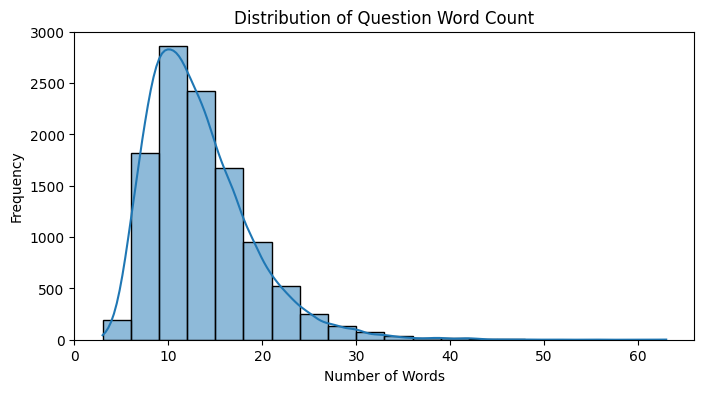

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['question_word_count'], bins=20, kde=True)
plt.title('Distribution of Question Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# **Preprocessing**

### BERT

During the preprocessing phase of my NLP project, I carefully considered several common text-cleaning and preparation techniques. Below is a breakdown of each step, whether I used it, and the reasoning behind my decision.

1. **Tokenization**  
   ✅ *Used*  
   I used the `BertTokenizer` from Hugging Face to tokenize all text inputs. This tokenizer breaks text into subword units and adds special tokens, ensuring compatibility with the BERT model architecture.

2. **Lowercasing, Stemming, Lemmatizing, Stopword/Punctuation Removal**  
   ❌ *Not used*  
   These steps are common in traditional NLP pipelines but not necessary when using a pre-trained transformer like BERT. I specifically used the `'bert-base-cased'` model, which is sensitive to letter casing. Applying lowercasing or stripping punctuation could disrupt the model's understanding of context. Similarly, stemming or lemmatizing would interfere with subword tokenization, which already handles morphological variations effectively.

3. **Removal of Unknown/Other Words**  
   ❌ *Not explicitly used*  
   Instead of manually removing unknown words, I relied on the tokenizer to handle them. Words not in the vocabulary are broken into subword tokens or mapped to the `[UNK]` token if completely unrecognized. BERT is designed to handle such cases gracefully.

4. **Format Cleaning (e.g., HTML-extracted text)**  
   ✅ *Used when necessary*  
   While my dataset (CommonsenseQA) was fairly clean, I included basic text normalization steps to remove potential noise (e.g., HTML entities) as a precaution in other stages of the pipeline.

5. **Truncation**  
   ✅ *Used*  
   To fit input sequences into BERT's maximum input size constraint, I applied truncation during tokenization. This ensures that long question-choice pairs are trimmed to 128 tokens, which balances performance and memory usage.

6. **Feature Selection**  
   ✅ *Used implicitly*  
   Rather than traditional feature engineering, I relied on the tokenized outputs (`input_ids`, `attention_mask`, `token_type_ids`) generated by the tokenizer. These features are optimized for transformer models and encapsulate the essential linguistic structure needed for training.

By tailoring preprocessing to suit BERT’s architecture, I avoided redundant or harmful steps while retaining the ones critical for accurate and efficient model performance.

---

The BertTokenizer is a class from the Hugging Face `transformers` library that handles the conversion of raw text into tokens that BERT can understand. Specifically, it tokenizes the input text into subword tokens (e.g., "playing" becomes ["play", "##ing"]). This subword tokenization allows the model to process both common and out-of-vocabulary words more effectively. The `from_pretrained('bert-base-cased')` method loads a pre-trained tokenizer that corresponds to the BERT model. The `'bert-base-cased'` model refers to a base-sized BERT model (with 12 layers and 768 hidden units) that has been trained on cased text, meaning it differentiates between uppercase and lowercase letters which is important for distinguishing meaning in proper nouns or acronyms (e.g., “US” vs “us”).

**Why I use BertTokenizer:** I use the BertTokenizer to ensure that the text is processed in the exact way BERT was originally trained. 

**The tokenizer will:** 
- Split the text into subword tokens. 
- Add special tokens such as `[CLS]` and `[SEP]` that BERT requires. 
- Handle padding and truncation to ensure the input is the correct length for the model.

I use the following line of code to initialize the BERT tokenizer.

In [16]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-cased')

c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The `preprocess_commonsenseqa` function is designed to preprocess the CommonsenseQA dataset for input into a BERT-based model. The goal is to tokenize the questions and their corresponding multiple-choice answers into a format compatible with BERT, and then convert the correct answer's label into a numerical value.

1. **Extracting Questions and Choices:** The function starts by extracting the questions and their multiple-choice options from the `examples` object.

2. **Initialize Data Structures:** It then initializes empty lists to hold the tokenized inputs, attention masks, and token type IDs (used for differentiating between sentence pairs in models like BERT).

3. **Convert Answer Labels to Indices:** The answer choices are labeled with letters (A, B, C, D, E), but the model requires numerical labels. This step converts the letters into indices (A → 0, B → 1, etc.).

4. **Processing Each Question-Choice Pair:** For each question and its corresponding choices: Each choice is paired with the question. Both the question and the choice are tokenized using the BERT tokenizer (`tokenizer_bert`), which converts the text into `input_ids`, `attention_mask` and `token_type_ids` tensors that BERT can understand.

5. **Stacking Tokens for Each Choice:** After tokenizing each choice for a question, the function stacks the resulting tensors (for all choices) into single tensors for input to the model.

6. **Returning Tokenized Data:** Finally, the function returns a dictionary containing the tokenized inputs (`input_ids`, `attention_mask` and `token_type_ids`) along with the numerical labels corresponding to the correct answers.

In [17]:
def preprocess_commonsenseqa(examples):

    questions = [q for q in examples['question']]
    
    all_input_ids = []
    all_attention_mask = []
    all_token_type_ids = []
    
    answerkeys = examples['answerKey']
    labels = []
    
    for key in answerkeys:
        labels.append(ord(key) - ord('A'))
    
    for i, (question, choices) in enumerate(zip(questions, examples['choices'])):
        inputs = []

        for choice in choices['text']:
            text_a = question
            text_b = choice
            
            encoded = tokenizer_bert(
                text_a, text_b,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            inputs.append({
                'input_ids': encoded['input_ids'],
                'attention_mask': encoded['attention_mask'],
                'token_type_ids': encoded['token_type_ids']
            })
        
        input_ids = torch.cat([x['input_ids'] for x in inputs])
        attention_mask = torch.cat([x['attention_mask'] for x in inputs])
        token_type_ids = torch.cat([x['token_type_ids'] for x in inputs])
        
        all_input_ids.append(input_ids)
        all_attention_mask.append(attention_mask)
        all_token_type_ids.append(token_type_ids)

    return {
        'input_ids': all_input_ids,
        'attention_mask': all_attention_mask,
        'token_type_ids': all_token_type_ids,
        'labels': labels
    }

Next, I apply the preprocessing to the datasets.

In [18]:
train_dataset = preprocess_commonsenseqa(train)
validation_dataset = preprocess_commonsenseqa(valid)
test_dataset = preprocess_commonsenseqa(test)

After preprocessing the CommonsenseQA dataset into tokenized inputs and labels, I convert the data into PyTorch `TensorDataset` objects. I do this because this groups all of the input tensors, so they can be iterated over together. It seamlessly integrates with PyTorch’s `DataLoader` for tasks like batching, shuffling and parallel data loading, ensuring that the data pipeline runs efficiently. Additionally, it provides synchronized indexing, ensuring that each input tensor corresponds correctly to its label, making the dataset ready for model training and evaluation.

In [19]:
train_features = TensorDataset(
    torch.stack(train_dataset['input_ids']),
    torch.stack(train_dataset['attention_mask']),
    torch.stack(train_dataset['token_type_ids']),
    torch.tensor(train_dataset['labels'])
)

val_features = TensorDataset(
    torch.stack(validation_dataset['input_ids']),
    torch.stack(validation_dataset['attention_mask']),
    torch.stack(validation_dataset['token_type_ids']),
    torch.tensor(validation_dataset['labels'])
)

test_features = TensorDataset(
    torch.stack(test_dataset['input_ids']),
    torch.stack(test_dataset['attention_mask']),
    torch.stack(test_dataset['token_type_ids']),
    torch.tensor(test_dataset['labels'])
)

### DeepSeek

For tokenizing my LLM I used the AutoTokenizer from Hugging Face to load the tokenizer for the DeepSeek-V2-Lite model. This tokenizer is specifically designed to be compatible with the DeepSeek model architecture. Since DeepSeek is a large language model (LLM), it expects input in a specific tokenized format, including proper handling of special tokens, padding and prompt formatting. By using the `AutoTokenizer` and loading the tokenizer directly from the model’s Hugging Face repository, I ensure that the text is processed exactly as the model was trained on.

The `trust_remote_code=True` argument is necessary because DeepSeek uses custom model/tokenizer code not yet fully integrated into the standard Transformers library. This option allows the tokenizer to load correctly and function as intended.

In short, I use this tokenizer to guarantee consistency between my input prompts and the expectations of the DeepSeek model, which is crucial for generating accurate and meaningful responses.

In [20]:
tokenizer_deepseek = AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-V2-Lite', trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# **Model**

To see the number of parameters for my models a bit better, I first implemented a function which adds an apostrophe after every three digits.

In [21]:
def format_number(num):
    return f"{num:,}".replace(",", "'")

### BERT

For the random initialized and the pretrained transformer architechture, I used BERT (Bidirectional Encoder Representations from Transformers) with a classification head specifically designed for multiple-choice inputs called `BertForMultipleChoice`. I used the Hugging Face checkpoint `bert-base-cased`, which is a pretrained transformer model developed by Google with **108'311'041 parameters**. This variant is trained on large English corpora (BooksCorpus and English Wikipedia) and maintains case sensitivity.

BERT is well-suited for classification tasks like CommonsenseQA due to its deep bidirectional attention, which helps capture the nuanced relationships between the question and each answer option. The pretrained bert-base-cased weights provide strong language understanding out of the box, significantly improving performance over training from scratch.

The BERT model is composed of an embedding layer, encoder, pooling layer, dropout layer and of course a classifier:

1. **Embedding Layer (`BertEmbeddings`):**
- Word Embeddings: `Embedding(28996, 768)` → Maps each token to a 768-dimensional vector. The vocabulary size is 28,996 tokens.
- Position Embeddings: `Embedding(512, 768)` → Adds position information to each token, allowing the model to distinguish word order up to 512 tokens.
- Token Type Embeddings: `Embedding(2, 768)` → Distinguishes between sentence pairs (e.g., question vs. answer).
- Layer Normalization + Dropout: Normalizes embeddings and applies dropout (`p=0.1`) for regularization.

2. **Encoder (`BertEncoder`):**
- 12 Transformer Layers (stacked) → Each layer includes:
    - Multi-Head Self-Attention (BertSelfAttention)
        - Projects inputs into queries, keys and values using linear layers.
        - Attention mechanism allows each token to attend to all others.
        - Output passed through a linear layer, then dropout + layer norm.
    - Feed-Forward Network
        - First Linear: `768 → 3072`
        - GELU activation
        - Second Linear: `3072 → 768`
        - Followed by LayerNorm and Dropout.
- Each of these layers processes the tokenized question-choice pair, allowing the model to capture deep contextual relationships.

3. **Pooling Layer (`BertPooler`):**
- Extracts the `[CLS]` token output from the final encoder layer.
- Applies a linear layer + `tanh` activation to produce a fixed-size sentence representation.

4. **Dropout Layer:**
- Applied before classification to reduce overfitting (`p=0.1`).

5. **Classifier (`Linear(768 → 1)`):**
- For each choice, outputs a single logit.
- During training/evaluation, logits for all choices are grouped and passed through softmax to compute the predicted answer.

---

In the following code block I load the configuration of the `'bert-base-cased'` model, but without the model weights. I just load the architecture details like number of layers, hidden size and so on. After I create a `BertForMultipleChoice` model using that configuration. This model is randomly initialized, meaining it hasn't learned anything yet.

In [22]:
config_bert = BertConfig.from_pretrained('bert-base-cased')
random_bert_model = BertForMultipleChoice(config_bert)

Next, I calculate and print the total number of parameters of the `random_bert_model` and then print its architecture.

In [23]:
print(f"Number of parameters: {format_number(sum(p.numel() for p in random_bert_model.parameters()))}\n")
print(random_bert_model)

Number of parameters: 108'311'041

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In the next cell I create a `BertForMultipleChoice` model with already pretrained weights. These pretrained weights allow my model to already understand some word meanings, grammar and general language patterns. This helps the model perform better and converge faster when fine-tuned on my specific downstream task, such as multiple-choice question answering with CommonsenseQA.

In [24]:
pretrained_bert_model = BertForMultipleChoice.from_pretrained('bert-base-cased')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


I calculate and print the total number of parameters of the `pretrained_bert_model` and then print its architecture.

In [25]:
print(f"Number of parameters: {format_number(sum(p.numel() for p in pretrained_bert_model.parameters()))}\n")
print(pretrained_bert_model)

Number of parameters: 108'311'041

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

### DeepSeek-V2-Lite

The `DeepSeek-V2-Lite` is a cutting-edge decoder-only transformer model optimized for causal language modeling, so for generating or completing text. With **15'706'484'224 parameters**, it is orders of magnitude larger than BERT and is specifically designed for autoregressive generation tasks.

For the DeepSeek-V2-Lite model, the architecture is composed of an embedding layer, a stack of decoder layers (transformer blocks), normalization layers and a final language modeling head for token prediction:

1. **Token Embedding Layer:**
- `Embedding(102400, 2048)` → Maps tokens from a very large vocabulary (102,400 tokens) to 2048-dimensional embeddings.

2. **Stack of 27 Decoder Layers (`DeepseekV2DecoderLayer`):**
- Each decoder layer includes:
    - Self-Attention Mechanism (`DeepseekV2Attention`)
        - Query projection: `Linear(2048 → 3072)`
        - KV projections:
            - `kv_a_proj_with_mqa`: `Linear(2048 → 576)` — Multi-query attention (MQA), a memory-efficient variant.
            - `kv_b_proj`: `Linear(512 → 4096)` — Advanced attention processing.
        - RMSNorm on KV inputs: Normalizes activations to improve stability.
        - Rotary Embeddings (`DeepseekV2YarnRotaryEmbedding`) → Positional encoding mechanism that enables extrapolation to longer sequences.
        - Output projection: `Linear(2048 → 2048)`
    - Feed-Forward Layer
        - Layer 0 uses:
            - Standard MLP (`DeepseekV2MLP`)
                - `gate_proj`, `up_proj`: `2048 → 10944`
                - `down_proj`: `10944 → 2048`
                - Activation: SiLU (a smooth, non-monotonic function similar to Swish)
        - Layers 1–26 use:
            - Mixture-of-Experts (MoE) Layer (`DeepseekV2MoE`)
                - 64 expert MLPs (`DeepseekV2MLP`) with `2048 → 1408 → 2048`
                - Gating mechanism: `MoEGate()` dynamically selects top-k experts per token.
                - Shared expert also included: `2048 → 2816 → 2048`
                - This makes computation sparse but increases capacity massively.
    - Normalization
        - RMSNorm instead of LayerNorm, used both before attention and before MLP. RMSNorm scales activations based on root mean square, which is more numerically stable in large-scale training.

3. **Final LayerNorm + Output Head:**
- Final RMSNorm applied to the output of the last decoder layer.
- LM Head: `Linear(2048 → 102400)`
    - Maps model outputs back into the token vocabulary for prediction.
    - Weight sharing is likely applied with the token embedding layer.

---

With the following code cell I load the `DeepSeek-V2-Lite` large language model (https://huggingface.co/deepseek-ai/DeepSeek-V2-Lite). This model is designed for causal language modeling tasks such as text generation. The loading configuration includes:
- `BitsAndBytesConfig`: Configures 8-bit quantization for more efficient memory usage.
  - `load_in_8bit=True`: Enables 8-bit quantization.
  - `llm_int8_threshold=6.0`: Sets the threshold for the outlier detection.
  - Other parameters to control the quantization behavior.
- `AutoModelForCausalLM.from_pretrained(...)`: Loads the pretrained DeepSeek model.
  - `quantization_config=bnb_config`: Applies the 8-bit quantization configuration.
  - `device_map={"": 0}`: Maps the model to GPU device 0.
  - `trust_remote_code=True`: Allows loading custom model code from the model's repository.
- `GenerationConfig.from_pretrained(...)`: Loads the model's default generation configuration (e.g., max tokens, sampling strategy).
- `pad_token_id = eos_token_id`: Sets the padding token to be the same as the end-of-sequence token for compatibility during generation.
- A print statement at the end confirms which device the model is loaded on.

In [26]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_skip_modules=None,
    llm_int8_enable_fp32_cpu_offload=False
)

deepseek_model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-V2-Lite",
    quantization_config=bnb_config,
    device_map={"": 0},
    trust_remote_code=True
)
deepseek_model.generation_config = GenerationConfig.from_pretrained('deepseek-ai/DeepSeek-V2-Lite')
deepseek_model.generation_config.pad_token_id = deepseek_model.generation_config.eos_token_id
print(next(deepseek_model.parameters()).device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

cuda:0


I calculate and print the total number of parameters of the `deepseek_model` and then print its architecture.

In [27]:
print(f"Number of parameters: {format_number(sum(p.numel() for p in deepseek_model.parameters()))}\n")
print(deepseek_model)

Number of parameters: 15'706'484'224

DeepseekV2ForCausalLM(
  (model): DeepseekV2Model(
    (embed_tokens): Embedding(102400, 2048)
    (layers): ModuleList(
      (0): DeepseekV2DecoderLayer(
        (self_attn): DeepseekV2Attention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=3072, bias=False)
          (kv_a_proj_with_mqa): Linear8bitLt(in_features=2048, out_features=576, bias=False)
          (kv_a_layernorm): DeepseekV2RMSNorm()
          (kv_b_proj): Linear8bitLt(in_features=512, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): DeepseekV2YarnRotaryEmbedding()
        )
        (mlp): DeepseekV2MLP(
          (gate_proj): Linear8bitLt(in_features=2048, out_features=10944, bias=False)
          (up_proj): Linear8bitLt(in_features=2048, out_features=10944, bias=False)
          (down_proj): Linear8bitLt(in_features=10944, out_features=2048, bias=False)
          (act_fn): SiL

The function `process_commonsense_qa_for_deepseek(...)` in the next code cell is designed to process and evaluate the performance from the LLM on the CommonsenseQA dataset. Rather than using the dataset in a traditional classification setup (with logits over classes), this function reformulates each question into a text prompt that uses one "few shot example" and chain-of-thought reasoning to guide the model toward selecting the correct answer choice.

Key features of the function include:
- **Few-shot Learning**: Includes 5 detailed examples with step-by-step reasoning to help the model understand the task format and reasoning process.
- **Prompt Construction**: Each question is converted into a formatted prompt including the question and multiple choice options labeled A–E, followed by "Let's think step by step."
- **Batch Processing**: Processes examples in batches for more efficient evaluation, with configurable batch size.
- **Text Generation**: The model generates longer responses (default `max_new_tokens=30`) to allow for step-by-step reasoning. → I tried different values and 30 had the best accuracy-to-performance trade-off.
- **Answer Extraction**: Uses regex pattern matching to extract the final answer letter from the chain-of-thought response, looking for patterns like "So the answer is: X".
- **Fallback Mechanism**: If the expected pattern isn't found, it searches for any standalone letters (A-E). If also not found it chooses randomly.
- **Memory Management**: Includes garbage collection to free memory between batches.
- **Result Logging**: Collects questions, prompts, full generated responses, ground truth labels and accuracy metrics for comprehensive evaluation.
- **Progress Tracking**: Uses tqdm to display a progress bar during evaluation (Updates per batch).

The function returns a dictionary with all results and prints the final accuracy score.

In [28]:
def process_commonsense_qa_for_deepseek(dataset, model, tokenizer, num_examples, max_new_tokens=100, batch_size=32):
    results = {
        'questions': [],
        'prompts': [],
        'responses': [],
        'raw_responses': [],
        'correct_answers': [],
        'is_correct': [],
        'is_from_fallback': [],
        'pattern_matched': [],
        'index_in_dataset': []
    }

    if num_examples is not None:
        limited_dataset = dataset.select(range(min(num_examples, len(dataset))))
    else:
        limited_dataset = dataset

    has_question_concept = 'question_concept' in limited_dataset.column_names
    total = len(limited_dataset)

    pbar = tqdm(total=total, desc="Generating answers")
    count_fallbacks = 0
    count_direct_matches = 0
    correct_from_fallback = 0
    correct_from_direct = 0

    for batch_start in range(0, total, batch_size):
        batch_end = min(batch_start + batch_size, total)

        batch_questions = []
        batch_prompts = []
        batch_answer_keys = []
        batch_indices = []

        for i in range(batch_start, batch_end):
            question = limited_dataset['question'][i]
            question_concept = limited_dataset['question_concept'][i] if has_question_concept else ''
            choices = limited_dataset['choices'][i]
            choice_labels = choices['label']
            choice_texts = choices['text']
            answer_key = limited_dataset['answerKey'][i] if 'answerKey' in limited_dataset.column_names else "N/A"

            formatted_choices = "\n".join([f"{label}. {text}" for label, text in zip(choice_labels, choice_texts)])

            few_shot_example = (
                "Q: Where would you be most likely to see a stop sign?\n"
                "Choices:\n"
                "A. In a library\n"
                "B. On a highway\n"
                "C. In a bedroom\n"
                "D. On a boat\n"
                "E. In a refrigerator\n"
                "Let's think step by step. A stop sign is used to control traffic. You don't see it indoors. It's commonly found where vehicles are present. So the answer is: B\n\n"
                
                "Q: What is needed to make a cake?\n"
                "Choices:\n"
                "A. Gravel\n"
                "B. Cement\n"
                "C. Sand\n" 
                "D. Flour\n"
                "E. Plastic\n"
                "Let's think step by step. A cake is a baked food item. To make it, I need ingredients that can be mixed and baked. Flour is a basic ingredient in baking. Cement, sand, gravel and plastic are construction materials and not edible. So the answer is: D\n\n"
            )

            prompt = (
                few_shot_example +
                f"Q: {question}\nChoices:\n{formatted_choices}\nLet's think step by step."
            )

            batch_questions.append(question)
            batch_prompts.append(prompt)
            batch_answer_keys.append(answer_key)
            batch_indices.append(i)

        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        try:
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=False,
                    temperature=0.0,
                    top_p=1.0,
                    num_beams=1,
                    eos_token_id=tokenizer.eos_token_id,
                )

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            responses = []
            is_from_fallback_batch = []
            pattern_matched_batch = []
            raw_responses_batch = []
            
            patterns = [
                r"So the answer is[:\s]*([A-E])\b",
                r"[Tt]he answer is[:\s]*([A-E])\b", 
                r"[Tt]herefore,? the answer is[:\s]*([A-E])\b",
                r"I choose[:\s]*([A-E])\b",
                r"I select[:\s]*([A-E])\b",
                r"Option[:\s]*([A-E])\b",
                r"Choice[:\s]*([A-E])\b",
                r"correct option is[:\s]*([A-E])\b",
                r"correct answer must be[:\s]*([A-E])\b",
                r"answer is ([A-E])[.,]",
                r"([A-E]) is correct\b",
                r"correct choice is ([A-E])\b",
                r"best answer is ([A-E])\b"
            ]
            
            for prompt, out in zip(batch_prompts, decoded):
                response = out[len(prompt):].strip() if out.startswith(prompt) else out.strip()
                raw_responses_batch.append(response)
                
                final_answer = None
                matched_pattern = "None"
                
                for i, pattern in enumerate(patterns):
                    match = re.search(pattern, response)
                    if match:
                        final_answer = match.group(1)
                        matched_pattern = f"Pattern {i}: {pattern}"
                        count_direct_matches += 1
                        break
                
                used_fallback = False
                if final_answer is None:
                    count_fallbacks += 1
                    used_fallback = True
                    fallback = re.search(r'\b([A-E])\b', response)
                    final_answer = fallback.group(1) if fallback else random.choice(['A', 'B', 'C', 'D', 'E'])
                    matched_pattern = "Fallback" if fallback else "Random"
                
                responses.append(final_answer)
                is_from_fallback_batch.append(used_fallback)
                pattern_matched_batch.append(matched_pattern)

        except Exception as e:
            print(f"Error: {str(e)}")
            responses = [random.choice(['A', 'B', 'C', 'D', 'E']) for _ in range(len(batch_prompts))]
            is_from_fallback_batch = [True for _ in range(len(batch_prompts))]
            pattern_matched_batch = [f"Error: {str(e)}" for _ in range(len(batch_prompts))]
            raw_responses_batch = [f"Error: {str(e)}" for _ in range(len(batch_prompts))]

        batch_is_correct = [resp == ans for resp, ans in zip(responses, batch_answer_keys)]
        
        for is_correct, is_fallback in zip(batch_is_correct, is_from_fallback_batch):
            if is_correct and is_fallback:
                correct_from_fallback += 1
            elif is_correct and not is_fallback:
                correct_from_direct += 1

        results['questions'].extend(batch_questions)
        results['prompts'].extend(batch_prompts)
        results['responses'].extend(responses)
        results['raw_responses'].extend(raw_responses_batch)
        results['correct_answers'].extend(batch_answer_keys)
        results['is_correct'].extend(batch_is_correct)
        results['is_from_fallback'].extend(is_from_fallback_batch)
        results['pattern_matched'].extend(pattern_matched_batch)
        results['index_in_dataset'].extend(batch_indices)

        if 'inputs' in locals():
            del inputs
        if 'outputs' in locals():
            del outputs
        gc.collect()
        pbar.update(len(batch_prompts))

    pbar.close()

    accuracy = sum(results['is_correct']) / len(results['is_correct']) if results['is_correct'] else 0

    direct_predictions = [not fb for fb in results['is_from_fallback']]
    direct_count = sum(direct_predictions)
    fallback_count = len(results['is_from_fallback']) - direct_count
    
    direct_accuracy = correct_from_direct / direct_count if direct_count > 0 else 0
    fallback_accuracy = correct_from_fallback / fallback_count if fallback_count > 0 else 0
    
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"Direct Pattern Matches: {direct_count} ({direct_count/len(results['responses']):.1%})")
    print(f"Fallback Matches: {fallback_count} ({fallback_count/len(results['responses']):.1%})")
    print(f"Accuracy from Direct Matches: {direct_accuracy:.2%}")
    print(f"Accuracy from Fallbacks: {fallback_accuracy:.2%}")

    class_total = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    class_correct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    class_from_fallback = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    class_from_direct = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}
    
    for ans, pred, is_correct, is_fallback in zip(
        results['correct_answers'], 
        results['responses'], 
        results['is_correct'], 
        results['is_from_fallback']
    ):
        class_total[ans] = class_total.get(ans, 0) + 1
        if is_correct:
            class_correct[ans] = class_correct.get(ans, 0) + 1
        
        if is_fallback:
            class_from_fallback[pred] = class_from_fallback.get(pred, 0) + 1
        else:
            class_from_direct[pred] = class_from_direct.get(pred, 0) + 1
    
    print("\nPer-class accuracy:")
    for cls in ['A', 'B', 'C', 'D', 'E']:
        if class_total[cls] > 0:
            cls_acc = class_correct[cls] / class_total[cls]
            print(f"  Choice {cls}: {cls_acc:.2%} ({class_correct[cls]}/{class_total[cls]})")
    
    print("\nPrediction source distribution:")
    for cls in ['A', 'B', 'C', 'D', 'E']:
        total_pred = class_from_direct[cls] + class_from_fallback[cls]
        if total_pred > 0:
            print(f"  {cls}: {total_pred} predictions - {class_from_direct[cls]} direct ({class_from_direct[cls]/total_pred:.1%}), "
                  f"{class_from_fallback[cls]} fallback ({class_from_fallback[cls]/total_pred:.1%})")

    analysis_data = []
    for i in range(len(results['responses'])):
        analysis_data.append({
            'index': results['index_in_dataset'][i],
            'question': results['questions'][i],
            'correct_answer': results['correct_answers'][i],
            'predicted': results['responses'][i],
            'is_correct': results['is_correct'][i],
            'from_fallback': results['is_from_fallback'][i],
            'pattern_matched': results['pattern_matched'][i],
            'raw_response': results['raw_responses'][i][:100] + "..." if len(results['raw_responses'][i]) > 100 else results['raw_responses'][i]
        })

    results['analysis_data'] = analysis_data

    print("\nSample of incorrect predictions (first 3):")
    incorrect_samples = [item for item in analysis_data if not item['is_correct']][:3]
    for i, sample in enumerate(incorrect_samples):
        print(f"\nIncorrect Example {i+1}:")
        print(f"Question: {sample['question']}")
        print(f"Predicted: {sample['predicted']} (Expected: {sample['correct_answer']})")
        print(f"From Fallback: {sample['from_fallback']}")
        print(f"Pattern Matched: {sample['pattern_matched']}")
        print(f"Raw Response: {sample['raw_response']}")
    
    return results

# **Training**

I define all the needed hyperparameters for my <u>manual</u> training. Heres a description for all of the hyperparameters used:

`epochs:` Number of times the model goes through the entire training dataset. Set to 5 just for testing purposes and to ensure the training process runs without issues.<br>
`learning_rate:` Controls how much the model updates its weights with each step. Set to 1e-5, a common starting point for fine-tuning large transformer models like BERT to ensure stable convergence.<br>
`batch_size:` Number of samples processed together before updating model weights. Set to 32 to fit well in memory while still enabling effective gradient updates.<br>
`warmup_steps:` Gradually increases learning rate over the first training steps to avoid instability. Set to *10% of the total training steps.<br>
`gradient_clip_val:` Limits the maximum gradient norm to prevent exploding gradients. Set to 2.0, a widely used value in transformer training to keep updates stable.<br>
`save_interval:` Saves the model after every epoch.  Set to 1 to ensure that I always retain a recent model state and avoid accidental loss.<br>
`gradient_accumulation_steps:` Accumulates gradients over multiple steps before updating weights, effectively increasing the batch size. Set to 4, which combined with batch_size = 32 gives an effective batch size of 128, improving generalization.<br>
`patience:` Stops training early if validation performance doesn’t improve for the set amount of epochs. Set to 3, also mainly for testing purposes, to limit training time during development.<br>
`weight_decay:` Applies L2 regularization to discourage overly large weights and reduce overfitting. Set to 0.01, a typical value that works well with `AdamW`to maintain generalization.<br>

*For the warmup steps I found, that the value is often set to 5-10% of the total training steps (https://medium.com/better-ml/the-art-of-setting-learning-rate-eff11ac0a737). To get for example the 10%, I would use this code:  `warmup_steps = 0.1 * len(train_dataloader)`. Due to the fact, that I wanted to have all my hyperparameters in one block (including the batch size, which is needed for the dataloader after) I had to find a different way to calculate those 10%. A different way to calculate this would be: `warmup_steps = int(0.1 * len(train_features) / batch_size)`. With this approach I could create the dataloaders later, while having all necessary hyperparameters in one block.

In [29]:
epochs = 5
learning_rate = 1e-5
batch_size = 32
warmup_steps = int(0.1 * len(train_features) / batch_size) # 0.1 = 10% of training data
gradient_clip_val = 2.0
save_interval = 1
gradient_accumulation_steps = 4 # Effectively creates a batch size of 128 (batch_size * gradient_accumulation_steps)
patience = 3
weight_decay = 0.01

In the next code cell, I define the data loaders for training, validation and testing. A DataLoader is responsible for efficiently loading batches of data during training or evaluation. Here's a breakdown of the configuration used for each dataset:
- `train_features` / `val_features` / `test_features`: These are the preprocessed datasets for training, validation, and testing, respectively.
- `batch_size`: Controls how many samples are passed through the model at once; defined earlier to ensure consistency.
- `shuffle`:
    - Set to `True` for the training set to ensure that the model sees a different order of examples each epoch (helps generalization).
    - Set to `False` for validation and test sets to maintain deterministic behavior (important for consistent evaluation).
- `num_workers=4`: Enables parallel data loading using 4 subprocesses. This speeds up data fetching, especially when I/O or preprocessing is involved.
- `pin_memory=True`: Allows faster transfer of data from CPU to GPU by allocating the data in page-locked (pinned) memory — useful when training on a CUDA-enabled device.

In [30]:
train_dataloader = DataLoader(train_features, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_features, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_features, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

As stated in the markdown for the hyperparameters, I used a bit of a different calculation to declare the warmup steps. In the following code block, I look at the output value of both calculations to make sure that they're the same.

In [31]:
print(warmup_steps)
print(int(0.1 * len(train_dataloader)))

27
27


The following `train_transformer` function runs the full training process for a transformer model using PyTorch. It includes helpful features like saving progress (checkpoints), stopping early if the model stops improving, adjusting the learning rate during training, combining gradients across batches to save memory, and optionally tracking results using Weights & Biases (WandB).

**Inputs:**
- `model`: A transformer model compatible with HuggingFace Transformers API.
- `train_dataloader`, `val_dataloader`: DataLoaders for training and validation sets.
- `device`: The device to train on (e.g., `"cuda"` or `"cpu"`).
- `epochs`: Number of training epochs.
- `learning_rate`: Learning rate for the optimizer.
- `warmup_steps`: Warm-up steps for the scheduler. If `None`, defaults to one epoch's worth of steps.
- `log_wandb`: Whether to log metrics and configs to WandB.
- `gradient_clip_val`: Value for gradient clipping.
- `save_interval`: How often (in epochs) to save model checkpoints.
- `gradient_accumulation_steps`: Number of steps to accumulate gradients before updating weights.
- `patience`: Patience for early stopping.
- `weight_decay`: Adds L2 regularization to the optimizer, which helps with overfitting.
- `save_path`: Directory path to save checkpoints and the best model.

**1. Checkpoint Saving Setup**
- If `save_path` is provided:
  - Create the checkpoint directory (if it doesn't exist).
  - Define the path for saving the best model.

**2. Model Preparation**
- Move model to the specified `device` (CPU/GPU).
- Enable gradient checkpointing (reduces memory usage, especially for large transformer models).

**3. WandB Initialization**
- If `log_wandb` is `True`:
  - Import and initialize a Weights & Biases run.
  - Log key hyperparameters and metadata.

**4. Optimizer, Scheduler & Loss Setup**
- Optimizer: `AdamW`
  - I used it, because it decouples weight decay from the gradient update, improving generalization and stability for transformer-based models.
- Scheduler: Linear with warmup
  - `warmup_steps` defaults to 1 epoch’s steps if not specified.
- Loss Function: `CrossEntropyLoss`
  - I chose it, because it is the standard loss function for multi-class classification tasks and effectively penalizes incorrect predictions based on confidence.

**5. Training Loop (per Epoch)**

**a. Training Phase**
- Set model to `train()` mode.
- For each batch in `train_dataloader`:
  - Move inputs to `device`
  - Forward pass → compute loss and predictions
  - Scale loss for gradient accumulation
  - Backpropagate loss
  - Every `gradient_accumulation_steps`:
    - Clip gradients
    - Optimizer and scheduler step
    - Zero gradients
  - Log loss and update progress

- Compute epoch-level metrics:
  - Average training loss
  - Training accuracy

**b. Validation Phase**
- Set model to `eval()` mode
- Disable gradients with `torch.no_grad()`
- For each batch in `val_dataloader`:
  - Move inputs to `device`
  - Forward pass → compute loss and predictions

- Compute:
  - Average validation loss
  - Validation accuracy

**c. Logging**
- If WandB is enabled:
  - Log training/validation loss, accuracy, and learning rate

**d. Checkpointing**
- If `epoch % save_interval == 0`:
  - Save a checkpoint with:
    - Model state
    - Optimizer state
    - Scheduler state
    - Metadata

**e. Best Model Saving & Early Stopping**
- If validation accuracy is best so far:
  - Save model and checkpoint
  - Reset early stopping counter
- Else:
  - Increment counter
  - Stop training if counter > `patience`

**6. Load Best Model**
- If a best model was saved, reload its weights.

**7. Finalize WandB Run**
- If `log_wandb` is `True`, call `wandb.finish()`.

**Return Values**
- `model`: Trained transformer model
- `train_losses`: List of average training losses (per epoch)
- `val_accuracies`: List of validation accuracies (per epoch)


In [32]:
def train_transformer(model, train_dataloader, val_dataloader, device, 
                      epochs=10, learning_rate=1e-4, warmup_steps=None,
                      log_wandb=True, gradient_clip_val=5.0, save_interval=1,
                      gradient_accumulation_steps=4, patience=3,
                      weight_decay=0.001, save_path=None, existing_wandb_run=None):
        
    if save_path:
        checkpoint_dir = save_path
        os.makedirs(checkpoint_dir, exist_ok=True)
        best_model_path = os.path.join(checkpoint_dir, "best_transformer_model.pt")
    else:
        print("Warning: No save_path provided. Model and checkpoints will not be saved.")
        checkpoint_dir = None
        best_model_path = None
    
    model = model.to(device)
    model.gradient_checkpointing_enable()
    
    is_pretrained = hasattr(model.config, 'name_or_path') and 'bert' in model.config.name_or_path.lower()
    
    if is_pretrained:
        model_type_name = "pretrained_transformer"
    else:
        model_type_name = "random_transformer"
    
    if log_wandb:
        if existing_wandb_run is None:
            import wandb
            if not wandb.run:
                run_name = f"{model_type_name}-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
                wandb.init(
                    project="CommonsenseQA",
                    name=run_name,
                    config={
                        "learning_rate": learning_rate,
                        "epochs": epochs,
                        "batch_size": train_dataloader.batch_size,
                        "gradient_accumulation_steps": gradient_accumulation_steps,
                        "effective_batch_size": train_dataloader.batch_size * gradient_accumulation_steps,
                        "weight_decay": weight_decay,
                        "warmup_steps": warmup_steps,
                        "gradient_clip_val": gradient_clip_val,
                        "model_type": model_type_name,
                    })
                print(f"Initialized new wandb run with name: {run_name}")
        else:
            wandb = existing_wandb_run
            print(f"Using existing wandb run: {wandb.run.name}")
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    total_steps = len(train_dataloader) * epochs // gradient_accumulation_steps
    
    if warmup_steps is None:
        warmup_steps = len(train_dataloader)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=warmup_steps, 
        num_training_steps=total_steps
    )
    
    train_losses = []
    val_accuracies = []
    
    best_accuracy = 0.0
    early_stopping_counter = 0
    
    print(f"Training {model_type_name} model...")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        progress_bar = tqdm(train_dataloader, desc="Training")
        optimizer.zero_grad()
        
        for i, batch in enumerate(progress_bar):
            input_ids, attention_mask, token_type_ids, labels = [b.to(device) for b in batch]
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            epoch_correct += (preds == labels).sum().item()
            epoch_total += labels.size(0)
            
            loss_to_backward = loss / gradient_accumulation_steps
            loss_to_backward.backward()

            if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_dataloader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                if log_wandb and wandb.run:
                    wandb.log({"learning_rate": scheduler.get_last_lr()[0]})
            
            progress_bar.set_postfix({"loss": loss.item()})
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_dataloader)
        train_accuracy = epoch_correct / epoch_total
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}, accuracy: {train_accuracy:.4f}")
        
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in progress_bar:
                input_ids, attention_mask, token_type_ids, labels = [b.to(device) for b in batch]
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                
                loss = criterion(logits, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                progress_bar.set_postfix({"acc": correct/total})
            
        val_accuracy = correct / total
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracies.append(val_accuracy)
        print(f"Validation loss: {avg_val_loss:.4f}, accuracy: {val_accuracy:.4f}")

        if log_wandb and wandb.run:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": scheduler.get_last_lr()[0],
                "model_type": model_type_name
            })
        
        if checkpoint_dir and (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"{model_type_name}_checkpoint_epoch_{epoch+1}.pt")
            model_to_save = model.module if hasattr(model, 'module') else model
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model_to_save.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_accuracy': best_accuracy,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'model_type': model_type_name
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
        
        if best_model_path and val_accuracy > best_accuracy:
            best_accuracy = val_accuracy

            model_to_save = model.module if hasattr(model, 'module') else model
            best_model_path_with_type = os.path.join(os.path.dirname(best_model_path), 
                                                   f"best_{model_type_name}_model.pt")
            torch.save(model_to_save.state_dict(), best_model_path_with_type)
            print(f"Best model saved to {best_model_path_with_type}")
            
            best_checkpoint_path = os.path.join(checkpoint_dir, 
                                              f"best_{model_type_name}_checkpoint_epoch_{epoch+1}.pt")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model_to_save.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_accuracy': best_accuracy,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'model_type': model_type_name
            }
            torch.save(checkpoint, best_checkpoint_path)
            
            if log_wandb and wandb.run:
                wandb.run.summary["best_accuracy"] = best_accuracy
                wandb.run.summary["best_epoch"] = epoch + 1
                wandb.run.summary["model_type"] = model_type_name
            
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            print(f"No improvement for {early_stopping_counter} epochs")
            if early_stopping_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                if log_wandb and wandb.run:
                    wandb.run.summary["stopped_epoch"] = epoch + 1
                break
    
    if best_model_path and os.path.exists(best_model_path_with_type):
        model.load_state_dict(torch.load(best_model_path_with_type))
        print(f"Loaded best model from {best_model_path_with_type}")
    
    return model, train_losses, val_accuracies

The function in the next two cells are for training the pretrained and randomly initialized BERT models using the `train_transformer` function with specified hyperparameters and checkpoint saving enabled.

In [33]:
if activate_pretrained_bert_training == True:
    trained_pretrained_bert_model, trained_pretrained_bert_train_losses, trained_pretrained_bert_val_accuracies = train_transformer(
        pretrained_bert_model, 
        train_dataloader, 
        val_dataloader, 
        device,
        epochs=epochs,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        gradient_clip_val=gradient_clip_val,
        save_interval=save_interval,
        gradient_accumulation_steps=gradient_accumulation_steps,
        patience=patience,
        weight_decay=weight_decay,
        save_path=f"./checkpoints/pretrained_transformer-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    )

In [34]:
if activate_random_bert_training == True:    
    trained_random_bert_model, trained_random_bert_train_losses, trained_random_bert_val_accuracies = train_transformer(
        random_bert_model, 
        train_dataloader, 
        val_dataloader, 
        device,
        epochs=epochs,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        gradient_clip_val=gradient_clip_val,
        save_interval=save_interval,
        gradient_accumulation_steps=gradient_accumulation_steps,
        patience=patience,
        weight_decay=weight_decay,
        save_path=f"./checkpoints/random_transformer-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    )

### Sweep

To explore optimal hyperparameters for both the pretrained and randomly initialized BERT models, I defined two sweep functions: `run_sweep_pretrained` and `run_sweep_random`. Both make use of the `train_transformer` training loop and share the same sweep configuration values (project requirement). Each sweep run initializes a fresh instance of the corresponding model (to ensure that the model is being reset correctly) and runs training and validation with its own `wandb` session. At the end of each run, the best validation accuracy is logged for comparison. The sweep type is a bayesian sweep, so the selection of hyperparameter configurations for each subsequent run is guided by the performance of previous runs, aiming to efficiently converge on the most promising hyperparameter values that maximize validation accuracy.

Below is a breakdown of each hyperparameter and the rationale behind the selected values or ranges:

`batch_size`: `[32]` → previously defined `[8, 16, 32, 64]` (can be seen in some runs)
- **Reasoning:** A batch size of 32 was selected as a balance between stability of gradient updates and memory efficiency.
- **Fixed Value:** I kept it fixed in the end to reduce sweep complexity and because larger batches didn’t fit in GPU memory during preliminary testing.

`learning_rate`: `log_uniform_values from 1e-6 to 1e-4`
- **Why log scale:** Transformers are highly sensitive to the learning rate. Small changes can drastically affect convergence, making log scale more appropriate.
- **Range Justification:**
  - `1e-6`: For stable but slow training, often needed when fine-tuning pretrained models.
  - `1e-4`: Allows exploration of slightly more aggressive updates, particularly relevant for training randomly initialized models.

`weight_decay`: `log_uniform_values from 1e-6 to 1e-2`
- **Purpose:** Regularizes the model by penalizing large weights, helping to avoid overfitting.
- **Range Justification:**
  - `1e-6`: Minimal regularization—safe starting point, especially for pretrained models.
  - `1e-2`: Stronger regularization—useful for random initialization where overfitting can be more prevalent.

`gradient_clip_val`: `uniform from 0.5 to 2.0`
- **Reasoning:** Clipping prevents exploding gradients, especially useful in unstable early training phases (e.g., with untrained models).
- **Range Justification:**
  - Lower bound `0.5`: Conservative clipping.
  - Upper bound `2.0`: Allows gradients to retain enough magnitude for effective updates.

`gradient_accumulation_steps`: `[1, 2, 4]`
- **Motivation:** Simulates larger batch sizes without exceeding GPU memory. Helps smooth out noisy gradients, especially when using a small physical batch size.
- **Choice of Values:**
  - `1`: Baseline (no accumulation).
  - `2, 4`: Increased effective batch size without increasing memory usage.

`warmup_ratio`: `[0.1]`
- **Why 10%?** Warming up the learning rate over 10% of total steps helps stabilize training, especially early on.
- **Transformer Norm:** 0.1 is a standard warmup ratio in most BERT training pipelines (e.g., from the original BERT paper and HuggingFace defaults).

`epochs`: `[50]`
- **Why 50?** Ensures sufficient training time for convergence, particularly for the randomly initialized model which typically learns more slowly.
- **Avoiding Truncation:** Prevents early termination of sweeps before reaching peak performance.
- **Mitigated by Early Stopping:** Since I use patience-based early stopping, long epoch counts don't necessarily waste compute.

`patience`: `[5]`
- **Function:** Early stopping prevents overfitting and saves compute by halting training if validation accuracy doesn’t improve.
- **Why 5?** Allows for minor plateaus in learning, giving models a fair chance to recover while still avoiding prolonged stagnation.

In [35]:
def objective_function_pretrained(config=None):
    with wandb.init(
    project="CommonsenseQA",
    name=f"pretrained_transformer-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    ) as run:
        config = wandb.config

        pretrained_bert_model = BertForMultipleChoice.from_pretrained('bert-base-cased')

        train_batch_size = config.batch_size
        
        train_dataloader = DataLoader(train_features,
            batch_size=train_batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        
        val_dataloader = DataLoader(
            val_features,
            batch_size=train_batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
        
        unique_save_path = f"./checkpoints/sweep-{wandb.run.id}-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        
        trained_model, train_losses, val_accuracies = train_transformer(
            model=pretrained_bert_model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            device=device,
            epochs=config.epochs,
            learning_rate=config.learning_rate,
            warmup_steps=config.warmup_ratio * len(train_dataloader),
            gradient_clip_val=config.gradient_clip_val,
            save_interval=1,
            gradient_accumulation_steps=config.gradient_accumulation_steps,
            patience=config.patience,
            weight_decay=config.weight_decay,
            save_path=unique_save_path,
            log_wandb=True,
            existing_wandb_run=wandb
        )
        
        del trained_model
        torch.cuda.empty_cache()
        gc.collect()

        best_val_accuracy = max(val_accuracies)
        wandb.log({"best_val_accuracy": best_val_accuracy})
        return best_val_accuracy

def objective_function_random(config=None):
    with wandb.init(
    project="CommonsenseQA",
    name=f"random_transformer-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    ) as run:
        config = wandb.config

        config_bert = BertConfig.from_pretrained('bert-base-cased')
        random_bert_model = BertForMultipleChoice(config_bert)
        
        train_batch_size = config.batch_size
        
        train_dataloader = DataLoader(train_features,
            batch_size=train_batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        
        val_dataloader = DataLoader(
            val_features,
            batch_size=train_batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
        
        unique_save_path = f"./checkpoints/sweep-{wandb.run.id}-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        
        trained_model, train_losses, val_accuracies = train_transformer(
            model=random_bert_model,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            device=device,
            epochs=config.epochs,
            learning_rate=config.learning_rate,
            warmup_steps=config.warmup_ratio * len(train_dataloader),
            gradient_clip_val=config.gradient_clip_val,
            save_interval=1,
            gradient_accumulation_steps=config.gradient_accumulation_steps,
            patience=config.patience,
            weight_decay=config.weight_decay,
            save_path=unique_save_path,
            log_wandb=True,
            existing_wandb_run=wandb
        )
        
        del trained_model
        torch.cuda.empty_cache()
        gc.collect()
        
        best_val_accuracy = max(val_accuracies)
        wandb.log({"best_val_accuracy": best_val_accuracy})
        return best_val_accuracy

def run_sweep_pretrained(count):
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'name': 'pretrained_model_sweep',
        'parameters': {
            'batch_size': {
                'values': [32]
            },
            'learning_rate': {
                'distribution': 'log_uniform_values',
                'min': 1e-6,
                'max': 1e-4
            },
            'weight_decay': {
                'distribution': 'log_uniform_values',
                'min': 1e-6,
                'max': 1e-2
            },
            'gradient_clip_val': {
                'distribution': 'uniform',
                'min': 0.5,
                'max': 2.0
            },
            'gradient_accumulation_steps': {
                'values': [1, 2, 4]
            },
            'warmup_ratio': {
                'values': [0.1]
            },
            'epochs': {
                'values': [50]
            },
            'patience': {
                'values': [5]
            }
        }
    }
    
    sweep_id = wandb.sweep(sweep_config, project="CommonsenseQA")

    wandb.agent(sweep_id, function=objective_function_pretrained, count=count)

def run_sweep_random(count):
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'name': 'pretrained_model_sweep',
        'parameters': {
            'batch_size': {
                'values': [32]
            },
            'learning_rate': {
                'distribution': 'log_uniform_values',
                'min': 1e-6,
                'max': 1e-4
            },
            'weight_decay': {
                'distribution': 'log_uniform_values',
                'min': 1e-6,
                'max': 1e-2
            },
            'gradient_clip_val': {
                'distribution': 'uniform',
                'min': 0.5,
                'max': 2.0
            },
            'gradient_accumulation_steps': {
                'values': [1, 2, 4]
            },
            'warmup_ratio': {
                'values': [0.1]
            },
            'epochs': {
                'values': [50]
            },
            'patience': {
                'values': [5]
            }
        }
    }
    
    sweep_id = wandb.sweep(sweep_config, project="CommonsenseQA")
    
    wandb.agent(sweep_id, function=objective_function_random, count=count)

Run the sweep for the pretrained bert model.

In [36]:
if activate_pretrained_bert_sweep == True:
    print("Starting sweep for pretrained model...")
    run_sweep_pretrained(count=50)

Run the sweep for the random bert model.

In [37]:
if activate_random_bert_sweep == True:
    print("Starting sweep for randomly initialized model...")
    run_sweep_random(count=50)

# **Evaluation**

The function `evaluate_bert_transformer` in the next cell evaluates a fine-tuned BERT-like transformer model on a given dataset.

**Inputs**
- `model`: The trained transformer model to evaluate.
- `dataloader`: A PyTorch DataLoader object providing evaluation batches.
- `device`: The computation device (e.g., `'cuda'` or `'cpu'`).
- `show_confusion_matrix` (`bool`, default=`True`): Whether to display a confusion matrix.
- `save_path`: If provided, the confusion matrix will be saved to this path as a PNG image.

**Outputs**<br>
Returns a dictionary with the following metrics:
- `'accuracy'`: Overall accuracy.
- `'precision'`: Weighted precision (if all classes have predictions).
- `'recall'`: Weighted recall.
- `'f1_score'`: Weighted F1 score.
- `'confusion_matrix'`: A raw confusion matrix (as a NumPy array).
- `'per_class_accuracy'`: A dictionary mapping each class (A–E) to its individual accuracy.

**Notes**
- Assumes a 5-class classification task, where labels 0–4 are mapped to choices A–E.
- Uses `torch.max()` to get predicted labels from model logits.
- Handles class imbalance by computing weighted metrics.
- If some classes are missing in predictions, precision/recall/F1 may fall back to `None`.
- A confusion matrix is optionally shown and saved using Seaborn.

In [38]:
def evaluate_bert_transformer(model, dataloader, device, show_confusion_matrix=True, save_path=None):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluation")

        for batch in progress_bar:
            input_ids, attention_mask, token_type_ids, labels = [b.to(device) for b in batch]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)

    try:
        precision = precision_score(true_labels, predicted_labels, average='weighted')
        recall = recall_score(true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
    except:
        print("Warning: Some classes may not have predictions. Using only accuracy.")
        precision = recall = f1 = None

    cm = confusion_matrix(true_labels, predicted_labels)

    idx_to_label = {i: chr(65 + i) for i in range(5)}

    class_accuracies = {}
    for i in range(5):
        class_indices = np.where(np.array(true_labels) == i)[0]
        if len(class_indices) > 0:
            class_correct = sum([predicted_labels[j] == i for j in class_indices])
            class_accuracies[idx_to_label[i]] = class_correct / len(class_indices)
        else:
            class_accuracies[idx_to_label[i]] = 0

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1-Score: {f1:.4f}")
    print("Per-class accuracy:")
    for label, acc in class_accuracies.items():
        print(f"  Choice {label}: {acc:.4f}")
    print

    if show_confusion_matrix:
        labels = [idx_to_label[i] for i in range(5)]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'per_class_accuracy': class_accuracies,
    }

This function `evaluate_deepseek` evaluates predictions made by the `DeepSeek-V2-Lite` model using a `results` dictionary of string-based labels. It provides accuracy, precision, recall, F1 score and a confusion matrix.

Unlike `evaluate_bert_transformer`, which operates on a PyTorch model and dataloader, this function assumes that predictions and true labels are already collected as strings (e.g., `'A'`, `'B'`, ...) in a dictionary format.

**Parameters**
- `results` (`dict`): A dictionary with two keys:
  - `'correct_answers'`: List of true labels as strings (e.g., `["A", "C", ...]`)
  - `'responses'`: List of predicted labels as strings.
- `show_confusion_matrix` (`bool`, default=`True`): Whether to display a confusion matrix.
- `save_path` (`str`, default=`"deepseek_confusion_matrix.png"`): Where to save the matrix plot, if displayed.

**Output**<br>
Returns a dictionary with:
- `'accuracy'`: Overall classification accuracy.
- `'precision'`: Weighted precision.
- `'recall'`: Weighted recall.
- `'f1_score'`: Weighted F1 score.
- `'confusion_matrix'`: Raw confusion matrix as a NumPy array.
- `'per_class_accuracy'`: Accuracy per label (A–E) as a dictionary.

**Notes**
- Uses a hardcoded 5-class mapping: `'A'` → `0`, ..., `'E'` → `4`.
- Invalid predictions (not in `'A'-'E'`) are defaulted to label `0` (`'A'`).
- Applies the same metrics and structure as `evaluate_bert_transformer` for consistency.
- Handles label imbalance using weighted metrics.
- Displays a confusion matrix with class labels A–E and optionally saves it.

In [39]:
def evaluate_deepseek(results, show_confusion_matrix=True, save_path="deepseek_confusion_matrix.png"):
    label_to_idx = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    idx_to_label = {i: chr(65 + i) for i in range(5)}
    
    true_labels = [label_to_idx[label] for label in results['correct_answers']]
    predicted_labels = [label_to_idx[label] if label in label_to_idx else 0 for label in results['responses']]
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    try:
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    except:
        print("Warning: Some classes may not have predictions. Using only accuracy.")
        precision = recall = f1 = None
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_accuracies = {}
    for i in range(5):
        class_indices = np.where(np.array(true_labels) == i)[0]
        if len(class_indices) > 0:
            class_correct = sum([predicted_labels[j] == i for j in class_indices])
            class_accuracies[idx_to_label[i]] = class_correct / len(class_indices)
        else:
            class_accuracies[idx_to_label[i]] = 0
    
    print(f"Overall Accuracy: {accuracy:.4f}")
    if precision is not None:
        print(f"Overall Precision: {precision:.4f}")
        print(f"Overall Recall: {recall:.4f}")
        print(f"Overall F1-Score: {f1:.4f}")
    print("Per-class accuracy:")
    for label, acc in class_accuracies.items():
        print(f"  Choice {label}: {acc:.4f}")
    print()
    
    if show_confusion_matrix:
        labels = [idx_to_label[i] for i in range(5)]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix - DeepSeek-V2-Lite')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"Confusion matrix saved to {save_path}")
        plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'per_class_accuracy': class_accuracies,
    }

Before evaluating, I delete all the models to speed up the evaluation process.

In [40]:
del pretrained_bert_model
del random_bert_model
del deepseek_model
torch.cuda.empty_cache()
gc.collect()

216597

### Random Bert Model Evaluation

I initialize the random bert model again, to start with the evaluation.

In [41]:
config_bert = BertConfig.from_pretrained('bert-base-cased')
random_bert_model = BertForMultipleChoice(config_bert)

The next code cell does the following steps:
1. Loads the model weights from a saved checkpoint.
2. Moves the model to the specified `device` (e.g., GPU or CPU).
3. Sets the model to evaluation mode to disable dropout and gradient tracking.
4. Evaluates the model on the test dataset using the `evaluate_bert_transformer` function, saving the confusion matrix as an image.

Evaluation: 100%|██████████| 39/39 [07:07<00:00, 10.96s/it]


Overall Accuracy: 0.1818
Overall Precision: 0.1816
Overall Recall: 0.1818
Overall F1-Score: 0.1817
Per-class accuracy:
  Choice A: 0.1548
  Choice B: 0.1843
  Choice C: 0.1618
  Choice D: 0.2311
  Choice E: 0.1745


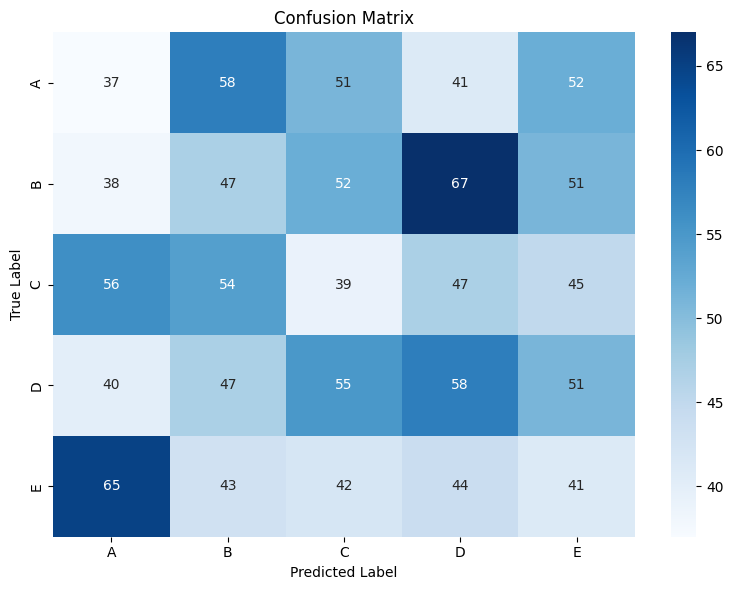

In [42]:
if activate_random_bert_evaluation == True:
    best_random_model_path = "./checkpoints/sweep-t666b3vz-2025-05-15_00-57-35/best_random_transformer_model.pt"
    random_bert_model.load_state_dict(torch.load(best_random_model_path))
    random_bert_model.to(device)
    random_bert_model.eval()
    test_results_random_model = evaluate_bert_transformer(random_bert_model, test_dataloader, device, save_path="random_bert_confusion_matrix.png")

After the evaluation is done for the random bert model, I delete it again to speed up the evaluation for the next two models.

In [43]:
del random_bert_model
torch.cuda.empty_cache()
gc.collect()

6215

### Pretrained Bert Model Evaluation

I initialize the pretrained bert model again, to start with the evaluation.

In [44]:
pretrained_bert_model = BertForMultipleChoice.from_pretrained('bert-base-cased')

c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The next code cell does the following steps:
1. Loads the model weights from a saved checkpoint.
2. Moves the model to the specified `device` (e.g., GPU or CPU).
3. Sets the model to evaluation mode to disable dropout and gradient tracking.
4. Evaluates the model on the test dataset using the `evaluate_bert_transformer` function, saving the confusion matrix as an image.

Evaluation: 100%|██████████| 39/39 [00:10<00:00,  3.70it/s]


Overall Accuracy: 0.5397
Overall Precision: 0.5393
Overall Recall: 0.5397
Overall F1-Score: 0.5394
Per-class accuracy:
  Choice A: 0.5732
  Choice B: 0.5686
  Choice C: 0.4855
  Choice D: 0.5538
  Choice E: 0.5149


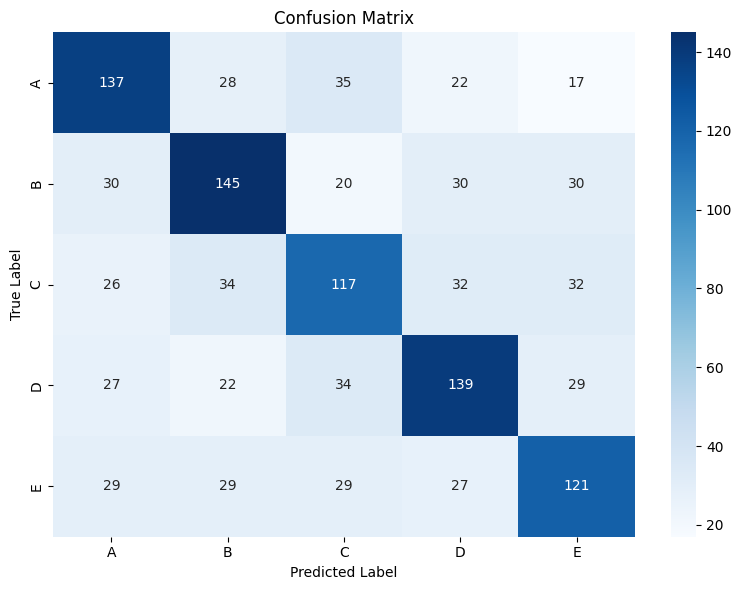

In [45]:
if activate_pretrained_bert_evaluation == True:
    best_pretrained_model_path = "./checkpoints/sweep-ui8fb374-2025-05-14_01-51-35/best_pretrained_transformer_model.pt"
    pretrained_bert_model.load_state_dict(torch.load(best_pretrained_model_path))
    pretrained_bert_model.to(device)
    pretrained_bert_model.eval()
    test_results_pretrained_model = evaluate_bert_transformer(pretrained_bert_model, test_dataloader, device, save_path="pretrained_bert_confusion_matrix.png")

After the evaluation is done for the pretrained bert model, I delete it again to speed up the evaluation for the next model.

In [46]:
del pretrained_bert_model
torch.cuda.empty_cache()
gc.collect()

6283

### Deepseek-V2-Lite Evaluation

I initialize the deepseek model again, to start with the evaluation.

In [47]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_skip_modules=None,
    llm_int8_enable_fp32_cpu_offload=False
)

deepseek_model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-V2-Lite",
    quantization_config=bnb_config,
    device_map={"": 0},
    trust_remote_code=True
)
deepseek_model.generation_config = GenerationConfig.from_pretrained('deepseek-ai/DeepSeek-V2-Lite')
deepseek_model.generation_config.pad_token_id = deepseek_model.generation_config.eos_token_id

c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Next, I run the `Deepseek-V2-Lite` model through the `process_commonsense_qa_for_deepseek` to evaluate the accuracy on the test dataset.

In [48]:
if activate_deepseek_evaluation == True:
    test_results_deepseek = process_commonsense_qa_for_deepseek(test, deepseek_model, tokenizer_deepseek, num_examples=len(test))

Generating answers:   0%|          | 0/1221 [00:00<?, ?it/s]c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Generating answers: 100%|██████████| 1221/1221 [3:53:23<00:00, 11.47s/it] 

Overall Accuracy: 60.52%
Direct Pattern Matches: 1187 (97.2%)
Fallback Matches: 34 (2.8%)
Accuracy from Direct Matches: 61.42%
Accuracy from Fallbacks: 29.41%

Per-class accuracy:
  Choice A: 64.85% (155/239)
  Choice B: 65.10% (166/255)
  Choice C: 63.07% (152/241)
  Choice D: 60.96% (153/251)
  Choice E: 48.09% (113/235)

Prediction source distribution:
  A: 264 predictions - 243 direct (92.0%), 21 fallback (8.0%)
  B: 265 predictions - 264 direct (99.6%), 1 fallback (0.4%)
  C: 252 predictions - 248 direct (98.4%), 4 fallback (1.6%)
  D: 240 predictions - 238 direct (99.2%), 2 fallback (0.8%)
  E: 200 predictions - 194 direct (97.0%), 6 fallback (3.0%)

Sample of incorrect predictions (first 3):

Incorrect Example 1:
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
Predicted: C (Expected: A)
From Fallback: False
Pattern Matched: Pattern 0: So the answer is[:\s]*([A-E])\b
Raw Response: A revolving door is used to c

Overall Accuracy: 0.6052
Overall Precision: 0.6046
Overall Recall: 0.6052
Overall F1-Score: 0.6038
Per-class accuracy:
  Choice A: 0.6485
  Choice B: 0.6510
  Choice C: 0.6307
  Choice D: 0.6096
  Choice E: 0.4809

Confusion matrix saved to deepseek_confusion_matrix.png


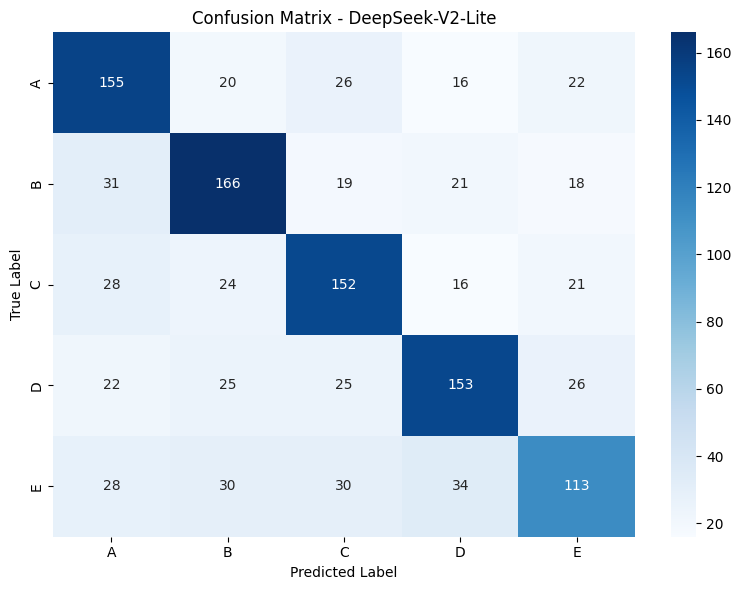

In [49]:
evaluation_metrics = evaluate_deepseek(test_results_deepseek)

After the evaluation of this model is also done, I delete it again to clean up the memory and resources.

In [50]:
del deepseek_model
torch.cuda.empty_cache()
gc.collect()

227264

# **Interpretation**

Before the project, my expectations were much higher than for the previous project, which resulted in an accuracy of around 23% (just slightly above random chance). I anticipated that with transformer model architectures and better tuning of hyperparameters, I would achieve noticeably higher accuracy this time. Specifically, I expected the randomly initialized transformer to perform slightly better than the previous RNN or word embedding. I also believed that the pretrained transformer would reach a solid accuracy, possibly around 60%, while the implemented large language model (LLM) might push accuracy even further, potentially up to 80%, due to the fact that my model had ~16B parameters. However, I was also aware that the complexity of the architecture itself could pose a significant challenge. Overall, I aimed for a meaningful improvement over the previous baseline and hoped to gain deeper insights into model behavior.

I initially expected the <u>**randomly initialized**</u> transformer to perform slightly better than random guessing, given that transformers are powerful architectures capable of learning complex patterns. However, the results showed a steady accuracy below 20%, which was surprisingly poor. This likely happened because training a transformer from scratch requires large amounts of data and careful tuning, which I did not have in this project. Without pretrained weights, the model had to learn both low-level and high-level features entirely from the limited dataset, which is a very challenging task. The architecture’s complexity might also have contributed to unstable training dynamics and slower convergence, resulting in suboptimal learning and poorer-than-random performance. Essentially, the model struggled to extract meaningful representations within the limited training time and data, leading to underwhelming accuracy.

For the <u>**pretrained transformer**</u>, my expectations were mostly met, as it achieved a solid accuracy of around 54%. This outcome aligns well with what is commonly observed when using pretrained models: they start with rich, general-purpose language representations learned from massive corpora, which allow them to adapt more quickly and effectively to downstream tasks. The pretrained weights give the model a strong head start, making it easier to fine-tune on smaller datasets and still achieve reasonably good performance. Although the accuracy was slightly below my initial estimate of 60%, it still demonstrates the power of transfer learning. I expected this because models like BERT are commonly used as a strong starting point in many language tasks and usually perform well. The good results from the pretrained model show how helpful it is to build on what the model has already learned from a lot of text, especially when you don’t have a lot of training data.

I expected the implemented <u>**large language model**</u> to reach a way higher accuracy, maybe around 80%, given its advanced architecture and training on vast datasets. However, the results were surprising and did not meet this optimistic estimate. Since I didn’t train the LLM but only used prompting to extract answers, its performance heavily depended on how well the prompt was designed and how suited the model was to this specific task. Factors like prompt wording, task complexity and domain mismatch likely limited its effectiveness. I struggled a lot with the bias of the LLM towards the first answer (A). I tried different methods, like increasing the few shot examples, maximum token length and even adjusting the parameters for the `generate` function. But nothing really seemed to help, it just made the bias bigger or even This experience highlights that even powerful models can have practical limitations when used off-the-shelf without fine-tuning or careful adaptation.

# **Tools used**

### **Adjust this section before submitting**

1. **Programming Environment**
   - Python 3.12.8
   - Jupyter Notebook

2. **Machine Learning and Deep Learning**
   - PyTorch (neural network development)
   - Hugging Face Datasets (data management)
   - NLTK (natural language preprocessing)
   - FastText (pre-trained word embeddings, 300-dimensional vectors)

3. **Data Manipulation and Analysis**
   - NumPy (numerical computing)
   - Pandas (data structuring and manipulation)
   - Scikit-learn (potential additional machine learning utilities)

4. **Visualization and Tracking**
   - Matplotlib (basic plotting)
   - Seaborn (statistical data visualization)
   - Weights & Biases (experiment tracking and logging)
     * Tracked metrics: training loss, accuracy, learning rates
     * Logged hyperparameter configurations
     * Enabled comparative analysis across model runs

5. **Computational Infrastructure**
   - CUDA-enabled GPU acceleration
   - GPU-optimized PyTorch operations
   - Efficient parallel computing for model training

6. **Dataset**
   - CommonsenseQA dataset (Hugging Face)

7. **Additional Libraries**
   - Gensim (word vector processing)
   - tqdm (progress bar visualization)
   - datetime (experiment timestamping)
   - os (file and path handling)
   - gc (manual garbage collection)
   - re (regular expressions)
   - random (random number generation and sampling)

8. **AI-Tools**
   - Claude 3.5 Sonnet: Utilized as a coding assistant for debugging, optimization and documentation.
   - GPT-4-turbo: Assisted in drafting and refining documentation, helping with structure and phrasing.
   - Copilot: Used for quick inserts, when recommendation was suitable for what I was planning to do.

9. **Sources**
   - CommonsenseQA dataset: https://huggingface.co/datasets/tau/commonsense_qa
   - Transformer architecture: https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb
   - Deepseek implementation: https://huggingface.co/deepseek-ai/DeepSeek-V2-Lite
   - Medium blog for warmup steps: https://medium.com/better-ml/the-art-of-setting-learning-rate-eff11ac0a737